# Импортируем библиотеки

In [ ]:
# Работа с операционной системой (файлы, переменные окружения)
import os

# Компьютерное зрение
import cv2

# Для работы с YAML-файлами
import yaml

# Для поиска файлов по шаблону
import glob

# Для случайного выбора элементов
import random

# Линейная алгебра
import numpy as np

# Обработка изображений
from PIL import Image

# Вместо цикла for для опитимизации
from itertools import repeat

# Для отрисовки изображений в Colab вместо cv2.imshow()
from google.colab.patches import cv2_imshow

# Работаем с фреймворком Keras и Tensorflow
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Add, Concatenate, Lambda
from tensorflow.keras.layers import Conv2D, Input, LeakyReLU
from tensorflow.keras.layers import MaxPool2D, UpSampling2D, ZeroPadding2D, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Графики
from matplotlib import pyplot as plt
%matplotlib inline

# Отключим мешаюшие предупреждения
import warnings
warnings.filterwarnings("ignore")

# Загрузка датасета

In [ ]:
!wget https://storage.yandexcloud.net/academy.ai/CV/chess_yolo.zip

--2025-06-22 09:43:11--  https://storage.yandexcloud.net/academy.ai/CV/chess_yolo.zip
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39275734 (37M) [application/x-zip-compressed]
Saving to: ‘chess_yolo.zip’

chess_yolo.zip      100%[===================>]  37.46M  12.6MB/s    in 3.0s    

2025-06-22 09:43:15 (12.6 MB/s) - ‘chess_yolo.zip’ saved [39275734/39275734]



In [ ]:
!unzip -qo "chess_yolo.zip"

In [ ]:
yaml_path = './chess_yolo/data.yaml'

Проверяем содержимое:

In [ ]:
!cat ./chess_yolo/data.yaml

path: ./chess_yolo

train: train/images
val: valid/images
test: test/images

names: 
  0: слон
  1: черный слон
  2: черный король
  3: черный конь
  4: черная пешка
  5: черный ферзь
  6: черная ладья
  7: белый слон
  8: белый король
  9: белый конь
  10: белая пешка
  11: белый ферзь
  12: белая ладья

Необходимо открыть data.yaml и удалить точку в пути:

path: ../chess_yolo -> ./chess_yolo

13 классов.

In [ ]:
def load_data(yaml_file):
    with open(yaml_file, 'r') as file:
        data = yaml.safe_load(file)
    return data

In [ ]:
# Загрузка данных из data.yaml
data = load_data('./chess_yolo/data.yaml')

data

{'path': './chess_yolo',
 'train': 'train/images',
 'val': 'valid/images',
 'test': 'test/images',
 'names': {0: 'слон',
  1: 'черный слон',
  2: 'черный король',
  3: 'черный конь',
  4: 'черная пешка',
  5: 'черный ферзь',
  6: 'черная ладья',
  7: 'белый слон',
  8: 'белый король',
  9: 'белый конь',
  10: 'белая пешка',
  11: 'белый ферзь',
  12: 'белая ладья'}}

In [ ]:
# Пути к данным
train_image_path = os.path.join(data['path'], data['train'])
train_label_path = os.path.join(data['path'], 'train', 'labels')
val_image_path = os.path.join(data['path'], data['val'])
val_label_path = os.path.join(data['path'], 'valid', 'labels')

# Количество классов
num_classes = len(data['names']) # 13

In [ ]:
print("Train images:", train_image_path)
print("Train labels:", train_label_path)
print("Val images:", val_image_path)
print("Val labels:", val_label_path)

Train images: ./chess_yolo/train/images
Train labels: ./chess_yolo/train/labels
Val images: ./chess_yolo/valid/images
Val labels: ./chess_yolo/valid/labels


In [ ]:
print("Train images count:", len(os.listdir(train_image_path)))
print("Train labels count:", len(os.listdir(train_label_path)))
print("Val images count:", len(os.listdir(val_image_path)))
print("Val labels count:", len(os.listdir(val_label_path)))

Train images count: 606
Train labels count: 606
Val images count: 58
Val labels count: 58


# Вспомогательные блоки

## DarkNet Block Layer (DBL)

In [ ]:
def DBL(x, filters, kernel, strides=1, batch_norm=True):
    if strides == 1:
        padding = 'same'
    else:
        # Делаем oтступ в виде нулей по контуру изображения, что бы захватить левый верхний угол
        x = ZeroPadding2D(((1, 0), (1, 0)))(x)
        padding = 'valid'
    x = Conv2D(filters=filters, kernel_size=kernel,
              strides=strides, padding=padding,
              use_bias=not batch_norm,  # используем смещение, если нет нормализации
              kernel_regularizer=l2(0.0005))(x)
    if batch_norm:
        x = BatchNormalization(epsilon=0.001)(x)
        x = LeakyReLU(negative_slope=0.1)(x)
    return x

## Блок ResUnit

In [ ]:
def ResUnit(x, filters):
    skip_connection  = x
    x = DBL(x, filters // 2, 1)
    x = DBL(x, filters, 3)
    x = Add()([skip_connection , x])
    return x

## Блок ResN

In [ ]:
def ResN(x, filters, blocks):
    x = DBL(x, filters, kernel=3, strides=2)
    for _ in repeat(None, blocks): # цикл по n-блокам (подход с repeat позволяет экономить память)
        x = ResUnit(x, filters)
    return x

# Сеть Darknet (BackBone)

In [ ]:
def Darknet(name=None):
    x = inputs = Input([None, None, 3])
    x = DBL(x, 32, 3)
    x = ResN(x, 64, 1)
    x = ResN(x, 128, 2)
    x = Route_1 = ResN(x, 256, 8)
    x = Route_2 = ResN(x, 512, 8)
    Route_3 = ResN(x, 1024, 4)
    return tf.keras.Model(inputs, (Route_1, Route_2, Route_3), name=name)

# Головы YOLOv3

In [ ]:
def YoloHead(filters, name=None):
    def layer(x_in):
        if isinstance(x_in, tuple): #
            inputs = Input(x_in[0].shape[1:]), Input(x_in[1].shape[1:])
            x, x_skip = inputs

            x = DBL(x, filters, 1)
            x = UpSampling2D(2)(x)
            x = Concatenate()([x, x_skip])
        else:
            x = inputs = Input(x_in.shape[1:])

        x = DBL(x, filters, 1)
        x = DBL(x, filters * 2, 3)
        x = DBL(x, filters, 1)
        x = DBL(x, filters * 2, 3)
        x = DBL(x, filters, 1)
        return Model(inputs, x, name=name)(x_in)
    return layer

def YoloHeadOutput(filters, anchors, classes, name=None):
    def layer(x_in):

        x = inputs = Input(x_in.shape[1:])
        x = DBL(x, filters * 2, 3)
        x = DBL(x, anchors * (classes + 5), 1, batch_norm=False)
        x = Lambda(lambda x: tf.reshape(x, (-1, tf.shape(x)[1], tf.shape(x)[2],
                                        anchors, classes + 5)))(x)
        return tf.keras.Model(inputs, x, name=name)(x_in)
    return layer

# Якорные рамки (anchor boxes) и ограничивающие рамки (bounding box)

In [ ]:
yolo_anchors = np.array([(10, 13), (16, 30), (33, 23), (30, 61), (62, 45),
                        (59, 119), (116, 90), (156, 198), (373, 326)], np.float32) / 416
yolo_anchor_masks = np.array([[6, 7, 8], [3, 4, 5], [0, 1, 2]])

# Функция преобразования предсказаных значений в рамки (yolo_boxes)

In [ ]:
def yolo_boxes(pred, anchors, classes):
    # На входе pred размера (S, S, 3, (1+4+80))

    grid_size = tf.shape(pred)[1] # S ячеек в сетке

    # В box_xy и box_wh помещаем сразу по 2 переменные (tx, ty) и (tw, th)
    box_xy, box_wh, score, class_probs = tf.split(pred, (2, 2, 1, classes), axis=-1) # раскладываем предсказанную карту по переменным

    # Применяем сигмоидные функции
    box_xy = tf.sigmoid(box_xy)
    score = tf.sigmoid(score)
    class_probs = tf.sigmoid(class_probs)
    pred_box = tf.concat((box_xy, box_wh), axis=-1)


    # Построим сетку S x S
    grid = tf.meshgrid(tf.range(grid_size), tf.range(grid_size))
    grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)

    # Привяжем box_xy к ячейкам сетки, учтем смещения (и снова нормируем к диапазону 0, 1)
    # Фактически мы вычисляем центральное положение рамки относительно размеров сетки (якорного поля)
    b_xy = (box_xy + tf.cast(grid, tf.float32)) /  tf.cast(grid_size, tf.float32) # вычисляем b_xy: (bx, by)

    b_wh = tf.exp(box_wh) * anchors # вычисляем b_wh: (bw, bh), ширина и высота рамки bbox

    box_x1y1 = b_xy - b_wh / 2
    box_x2y2 = b_xy + b_wh / 2
    bbox = tf.concat([box_x1y1, box_x2y2], axis=-1) # задаем рамку bbox, как 2 координаты углов


    return bbox, score, class_probs, pred_box

# Подавление не максимумов NMS

In [ ]:
def nonMaximumSuppression(outputs, anchors, masks, classes):
    boxes, conf, out_type = [], [], []

    # Блок преобразования трех выходов разных масштабов
    for output in outputs:
        boxes.append(tf.reshape(output[0], (tf.shape(output[0])[0], -1, tf.shape(output[0])[-1])))
        conf.append(tf.reshape(output[1], (tf.shape(output[1])[0], -1, tf.shape(output[1])[-1])))
        out_type.append(tf.reshape(output[2], (tf.shape(output[2])[0], -1, tf.shape(output[2])[-1])))

    # Конкатенируем три масштаба в один
    bbox = tf.concat(boxes, axis=1)
    confidence = tf.concat(conf, axis=1)
    class_probs = tf.concat(out_type, axis=1)

    scores = confidence * class_probs # Оценки считаем как произведение оценок объектности на вероятности классов

    # Применяем NMS из пакета tensorflow
    boxes, scores, classes, valid_detections = tf.image.combined_non_max_suppression(
        boxes=tf.reshape(bbox, (tf.shape(bbox)[0], -1, 1, 4)),
        scores=tf.reshape(
            scores, (tf.shape(scores)[0], -1, tf.shape(scores)[-1])),
        max_output_size_per_class=100,
        max_total_size=100,
        iou_threshold=YOLO_IOU_THRESHOLD,
        score_threshold=YOLO_SCORE_THRESHOLD)

    return boxes, scores, classes, valid_detections

# Сборка модели

Определим константы для модели:

In [ ]:
YOLO_IOU_THRESHOLD = 0.99 # порог для оценок перекрытия IOU в NMS (параметр iou_threshold в tf.image.combined_non_max_suppression)
YOLO_SCORE_THRESHOLD = 0.6 # порог для оценок scores применяется в NMS (параметр score_threshold в tf.image.combined_non_max_suppression)
SIZE = 416 # изменяем изображения до размеров
BATCH_SIZE = 2

In [ ]:
# CLASS_NAMES =  [
#     "слон",
#     "черный слон",
#     "черный король",
#     "черный конь",
#     "черная пешка",
#     "черный ферзь",
#     "черная ладья",
#     "белый слон",
#     "белый король",
#     "белый конь",
#     "белая пешка",
#     "белый ферзь",
#     "белая ладья"
#     ]
CLASS_NAMES = [
    "bishop",
    "black bishop",
    "black king",
    "black knight",
    "black pawn",
    "black queen",
    "black rook",
    "white bishop",
    "white king",
    "white knight",
    "white pawn",
    "white queen",
    "white rook"
    ]

Так как нам необходимо будет загрузить веса предобученной модели и определить имена слоев, в которые необходимо встроить предобученные веса.

In [ ]:
YOLO_V3_LAYERS = [
    'yolo_darknet',
    'yolo_head_1',
    'yolo_output_1',
    'yolo_head_2',
    'yolo_output_2',
    'yolo_head_3',
    'yolo_output_3'
]

Теперь собираем модель и не забываем именовать слои, которым необходимо задать веса.

In [ ]:
def YoloV3(size=None, channels=3, anchors=yolo_anchors,
            masks=yolo_anchor_masks, classes=13, training=False):
    # Вход
    x = inputs = Input([size, size, channels])

    # Модель Darknet с тремя выходами
    Route_1, Route_2, Route_3 = Darknet(name='yolo_darknet')(x)

    # Определяем 3 головы с разным числом фильтров
    x = YoloHead(512, name='yolo_head_1')(Route_3)
    output_0 = YoloHeadOutput(512, len(masks[0]), classes, name='yolo_output_1')(x)

    x = YoloHead(256, name='yolo_head_2')((x, Route_2))
    output_1 = YoloHeadOutput(256, len(masks[1]), classes, name='yolo_output_2')(x)

    x = YoloHead(128, name='yolo_head_3')((x, Route_1))
    output_2 = YoloHeadOutput(128, len(masks[2]), classes, name='yolo_output_3')(x)

    if training: # заложим модель для обучения (понадобиться в домашней работе)
        return Model(inputs, (output_0, output_1, output_2), name='yolov3')

    # Перегоняем предсказанные якорные рамки в boundary box для трех выходов
    boxes_0 = Lambda(lambda x: yolo_boxes(x, anchors[masks[0]], classes),
                  name='yolo_boxes_0')(output_0)
    boxes_1 = Lambda(lambda x: yolo_boxes(x, anchors[masks[1]], classes),
                  name='yolo_boxes_1')(output_1)
    boxes_2 = Lambda(lambda x: yolo_boxes(x, anchors[masks[2]], classes),
                  name='yolo_boxes_2')(output_2)

    # Отсекаем все лишнее алгоритмом NMS
    outputs = Lambda(lambda x: nonMaximumSuppression(x, anchors, masks, classes),
                  name='nonMaximumSuppression')((boxes_0[:3], boxes_1[:3], boxes_2[:3]))

    return Model(inputs, outputs, name='yolov3') # возвращаем модель для инференса

## Преобразование ограничивающих рамок

In [ ]:
@tf.function
def transform_targets_for_output(y_true, grid_size, anchor_idxs, classes):

    N = tf.shape(y_true)[0]

    y_true_out = tf.zeros(
      (N, grid_size, grid_size, tf.shape(anchor_idxs)[0], 6))

    anchor_idxs = tf.cast(anchor_idxs, tf.int32)

    indexes = tf.TensorArray(tf.int32, 1, dynamic_size=True)
    updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)
    idx = 0
    for i in tf.range(N):
        for j in tf.range(tf.shape(y_true)[1]):
            if tf.equal(y_true[i][j][2], 0):
                continue
            anchor_eq = tf.equal(
                anchor_idxs, tf.cast(y_true[i][j][5], tf.int32))

            if tf.reduce_any(anchor_eq):
                box = y_true[i][j][0:4]
                box_xy = (y_true[i][j][0:2] + y_true[i][j][2:4]) / 2

                anchor_idx = tf.cast(tf.where(anchor_eq), tf.int32)
                grid_xy = tf.cast(box_xy // (1/grid_size), tf.int32)

                indexes = indexes.write(
                    idx, [i, grid_xy[1], grid_xy[0], anchor_idx[0][0]])
                updates = updates.write(
                    idx, [box[0], box[1], box[2], box[3], 1, y_true[i][j][4]])
                idx += 1

    return tf.tensor_scatter_nd_update(
        y_true_out, indexes.stack(), updates.stack())


def transform_targets(y_train, anchors, anchor_masks, classes):
    outputs = []
    grid_size = 13

    anchors = tf.cast(anchors, tf.float32)
    anchor_area = anchors[..., 0] * anchors[..., 1]
    box_wh = y_train[..., 2:4] - y_train[..., 0:2]
    box_wh = tf.tile(tf.expand_dims(box_wh, -2),
                    (1, 1, tf.shape(anchors)[0], 1))
    box_area = box_wh[..., 0] * box_wh[..., 1]
    intersection = tf.minimum(box_wh[..., 0], anchors[..., 0]) * \
    tf.minimum(box_wh[..., 1], anchors[..., 1])
    iou = intersection / (box_area + anchor_area - intersection)
    anchor_idx = tf.cast(tf.argmax(iou, axis=-1), tf.float32)
    anchor_idx = tf.expand_dims(anchor_idx, axis=-1)

    y_train = tf.concat([y_train, anchor_idx], axis=-1)

    for anchor_idxs in anchor_masks:
        outputs.append(transform_targets_for_output(
            y_train, grid_size, anchor_idxs, classes))
        grid_size *= 2

    return tuple(outputs) # [x, y, w, h, obj, class]


def preprocess_image(x_train, size):
    return (tf.image.resize(x_train, (size, size))) / 255

# Вспомогательные функции

## Функции вычисления IoU

Функция interval_overlap вычисляет длину пересечения двух отрезков на одной оси (X или Y).

In [ ]:
def broadcast_iou(box_1, box_2):
    """
    Вычисляет IoU между всеми парами боксов.

    Args:
        box_1: shape=(..., num_pred, 4)
        box_2: shape=(..., num_gt, 4)

    Returns:
        iou: shape=(..., num_pred, num_gt)
    """

    box_1 = tf.expand_dims(box_1, -2)  # [..., num_pred, 1, 4]
    box_2 = tf.expand_dims(box_2, -3)  # [..., 1, num_gt, 4]

    b1_xy = box_1[..., :2]
    b1_wh = box_1[..., 2:4]
    b1_min = b1_xy - b1_wh / 2
    b1_max = b1_xy + b1_wh / 2

    b2_xy = box_2[..., :2]
    b2_wh = box_2[..., 2:4]
    b2_min = b2_xy - b2_wh / 2
    b2_max = b2_xy + b2_wh / 2

    intersect_mins = tf.maximum(b1_min, b2_min)
    intersect_maxes = tf.minimum(b1_max, b2_max)
    intersect_wh = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_area = intersect_wh[..., 0] * intersect_wh[..., 1]

    b1_area = b1_wh[..., 0] * b1_wh[..., 1]
    b2_area = b2_wh[..., 0] * b2_wh[..., 1]

    union_area = b1_area + b2_area - intersect_area
    iou = tf.clip_by_value(intersect_area / (union_area + 1e-7), 0., 1.)

    return iou

In [ ]:
def intersectionOverUnion(box1, box2):
    """
    Вычисляет IoU между двумя боксами в формате [xmin, ymin, xmax, ymax]

    Args:
        box1: tf.Tensor или numpy array, форма (4,)
        box2: tf.Tensor или numpy array, форма (4,)

    Returns:
        iou: float
    """
    # Координаты пересечения
    x1 = tf.maximum(box1[0], box2[0])  # xmin
    y1 = tf.maximum(box1[1], box2[1])  # ymin
    x2 = tf.minimum(box1[2], box2[2])  # xmax
    y2 = tf.minimum(box1[3], box2[3])  # ymax

    # Ширина и высота пересечения
    intersect_w = tf.maximum(x2 - x1, 0.)
    intersect_h = tf.maximum(y2 - y1, 0.)
    intersect_area = intersect_w * intersect_h

    # Площадь каждого бокса
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # Площадь объединения
    union_area = area1 + area2 - intersect_area

    # IoU
    iou = intersect_area / (union_area + 1e-6)  # избегаем деления на ноль
    return iou

def interval_overlap(interval_a, interval_b):
    """
    interval_a и interval_b — списки [start, end]
    """
    x_left = tf.maximum(interval_a[0], interval_b[0])
    x_right = tf.minimum(interval_a[1], interval_b[1])
    overlap = tf.maximum(x_right - x_left, 0.)
    return overlap

In [ ]:
# Пример двух боксов
box_a = tf.constant([0.1, 0.1, 0.4, 0.5], dtype=tf.float32)
box_b = tf.constant([0.2, 0.2, 0.5, 0.6], dtype=tf.float32)

iou = intersectionOverUnion(box_a, box_b)
print("IoU:", iou.numpy())

IoU: 0.3333315


## Функция потерь

In [ ]:
def YoloLoss(anchors, classes=80, ignore_thresh=0.5):
    def yolo_loss(y_true, y_pred):

        # 1. Преобразуем все предсказанные выходы
        # y_pred: (batch_size, grid, grid, anchors, (x, y, w, h, obj, ...cls))
        # с функцией yolo_boxes мы уже знакомы
        pred_box, pred_obj, pred_class, pred_xywh = yolo_boxes(
            y_pred, anchors, classes)
        pred_xy = pred_xywh[..., 0:2]
        pred_wh = pred_xywh[..., 2:4]

        # 2. Преобразуем все реальные значения
        # y_true: (batch_size, grid, grid, anchors, (x1, y1, x2, y2, obj, cls))
        true_box, true_obj, true_class_idx = tf.split(
            y_true, (4, 1, classes), axis=-1)
        # true_class_idx = tf.squeeze(true_class_idx, axis=-1)  # Убираем лишнюю ось
        true_xy = (true_box[..., 0:2] + true_box[..., 2:4]) / 2
        true_wh = true_box[..., 2:4] - true_box[..., 0:2]

        # Чем меньше рамка, тем больше ошибка
        box_loss_scale = 2 - true_wh[..., 0] * true_wh[..., 1]

        # 3. Инвертируем  уравнений красного прямоугольника inverting the pred box equations
        grid_size = tf.shape(y_true)[1]
        grid = tf.meshgrid(tf.range(grid_size), tf.range(grid_size))
        grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)
        true_xy = true_xy * tf.cast(grid_size, tf.float32) - \
            tf.cast(grid, tf.float32)
        true_wh = tf.math.log(true_wh / anchors)
        true_wh = tf.where(tf.math.is_inf(true_wh),
                      tf.zeros_like(true_wh), true_wh)

        # 4. Вычисляем ignore_mask
        obj_mask = tf.squeeze(true_obj, -1)
        true_box_flat = tf.boolean_mask(true_box, tf.cast(obj_mask, tf.bool))

        # best_iou = tf.reduce_max(intersectionOverUnion(
        #     pred_box, true_box_flat), axis=-1)
        # ignore_mask = tf.cast(best_iou < ignore_thresh, tf.float32)

        iou = broadcast_iou(pred_box, true_box_flat)
        best_iou = tf.reduce_max(iou, axis=-1)
        ignore_mask = tf.cast(best_iou < ignore_thresh, tf.float32)

        # 5. Вычисляем все функции ошибок
        xy_loss = obj_mask * box_loss_scale * \
            tf.reduce_sum(tf.square(true_xy - pred_xy), axis=-1)
        wh_loss = obj_mask * box_loss_scale * \
            tf.reduce_sum(tf.square(true_wh - pred_wh), axis=-1)

        obj_loss = binary_crossentropy(true_obj, pred_obj)
        obj_loss = obj_mask * obj_loss + \
            (1 - obj_mask) * ignore_mask * obj_loss

        # Можно использовать как binary_crossentropy, так и categorical_crossentropy
        class_loss = obj_mask * categorical_crossentropy(
            true_class_idx, pred_class)

        # 6. Все функции ошибок суммируются по осям для каждого пакета (batch, gridx, gridy, anchors) => (batch, 1)
        xy_loss = tf.reduce_sum(xy_loss, axis=(1, 2, 3))
        wh_loss = tf.reduce_sum(wh_loss, axis=(1, 2, 3))
        obj_loss = tf.reduce_sum(obj_loss, axis=(1, 2, 3))
        class_loss = tf.reduce_sum(class_loss, axis=(1, 2, 3))

        # Общая суммарная ошибка
        return xy_loss + wh_loss + obj_loss + class_loss
    return yolo_loss

## Функции детекции объектов и отображения предсказанной рамки

Функция `draw_outputs` отображает на изображении `img` ограничивающие рамки , имена классов, вероятности объектов, которые сетка нам предсказала.

Предсказанные данные для отображения вычисляются в функции `detect_objects`, которой на вход подается путь до изображения и `white_list` (используется для ограничения классов, по которым проводить детекцию).

In [ ]:
def draw_outputs(img, outputs, class_names, white_list=None):
    boxes, score, classes, nums = outputs # распознанные объекты
    boxes, score, classes, nums = boxes[0], score[0], classes[0], nums[0]
    wh = np.flip(img.shape[0:2]) # предсказанные ширина и высота
    for i in range(nums):
        # Отображаем объекты только из white_list
        if class_names[int(classes[i])] not in white_list:
            continue

        # Предсказанные координаты нижнего левого и правого верхнего углов
        x1y1 = tuple((np.array(boxes[i][0:2]) * wh).astype(np.int32))
        x2y2 = tuple((np.array(boxes[i][2:4]) * wh).astype(np.int32))

        # Рисуем прямоугольник по двум предсказанным координатам
        img = cv2.rectangle(img, x1y1, x2y2, (255, 0, 0), 1)

        # Выводим имя класса предсказанного объекта и оценку
        img = cv2.putText(img, '{} {:.2f}'.format(
            class_names[int(classes[i])], score[i]),
            x1y1, cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 0, 0), 1)
    return img

In [ ]:
def detect_objects(img_path, white_list=None):
    image = img_path # путь к файлу
    img = tf.image.decode_image(open(image, 'rb').read(), channels=3) # загружаем изображение как тензор

    img = tf.expand_dims(img, 0) # добавляем размерность
    img = preprocess_image(img, SIZE) # ресайзим изображение
    boxes, scores, classes = yolo.predict(img) # делаем предсказание

    img = cv2.imread(image) # считываем изображение как картинку, чтобы на нем рисовать
    # Отрисовываем на картинке предсказанные объекты
    img = draw_outputs(img, (boxes, scores, classes, nums), CLASS_NAMES, white_list)

    # Сохраняем изображения с предсказанными объектами
    cv2.imwrite('detected_{:}'.format(img_path), img)

    # Открываем сохраненные изображения и выводим на экран
    detected = Image.open('detected_{:}'.format(img_path))
    detected.show()
    plt.imshow(detected)

## Подготовка датасета

In [ ]:
@tf.function
def transform_targets_for_output(y_true, grid_size, anchor_idxs, classes):
    # classes — число классов (13)
    y_true_out = tf.zeros((grid_size, grid_size, tf.shape(anchor_idxs)[0], 5 + classes))

    anchor_idxs = tf.cast(anchor_idxs, tf.int32)
    indexes = tf.TensorArray(tf.int32, size=0, dynamic_size=True)
    updates = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
    idx = 0

    for j in tf.range(tf.shape(y_true)[0]):
        if tf.equal(y_true[j][2], 0):  # Пропуск пустых боксов
            continue

        anchor_eq = tf.equal(anchor_idxs, tf.cast(y_true[j][5], tf.int32))
        if tf.reduce_any(anchor_eq):
            box = y_true[j][0:4]
            box_xy = (box[0:2] + box[2:4]) / 2

            anchor_idx = tf.cast(tf.where(anchor_eq)[0][0], tf.int32)
            grid_xy = tf.cast(box_xy // (1.0 / grid_size), tf.int32)

            class_data = y_true[j][4:4+classes]  # one-hot вектор класса
            obj = 1.0  # объект присутствует

            # Соединяем координаты + obj + классы
            update = tf.concat([box, [obj], class_data], axis=-1)

            indexes = indexes.write(idx, [grid_xy[1], grid_xy[0], anchor_idx])
            updates = updates.write(idx, update)
            idx += 1

    return tf.tensor_scatter_nd_update(
        y_true_out, indexes.stack(), updates.stack())

In [ ]:
def transform_targets(y_train, anchors, anchor_masks, classes):
    outputs = []
    grid_size = 13

    anchors = tf.cast(anchors, tf.float32)
    anchor_area = anchors[..., 0] * anchors[..., 1]

    boxes_xywh = y_train[..., :4]
    class_ids = y_train[..., 4:5]
    class_one_hot = tf.one_hot(tf.cast(class_ids, tf.int32), depth=classes)

    # Убираем лишнюю размерность от one_hot
    class_one_hot = tf.squeeze(class_one_hot, axis=-2)

    box_wh = boxes_xywh[..., 2:4] - boxes_xywh[..., 0:2]
    box_wh = tf.expand_dims(box_wh, axis=-2)
    box_wh = tf.tile(box_wh, [1, tf.shape(anchors)[0], 1])

    box_area = box_wh[..., 0] * box_wh[..., 1]
    intersection = tf.minimum(box_wh[..., 0], anchors[..., 0]) * \
                   tf.minimum(box_wh[..., 1], anchors[..., 1])
    iou = intersection / (box_area + anchor_area - intersection)

    anchor_idx = tf.cast(tf.argmax(iou, axis=-1), tf.float32)
    anchor_idx = tf.expand_dims(anchor_idx, axis=-1)

    y_train = tf.concat([boxes_xywh, class_one_hot, anchor_idx], axis=-1)

    for anchor_idxs in anchor_masks:
        outputs.append(transform_targets_for_output(
            y_train, grid_size, anchor_idxs, classes))
        grid_size *= 2

    return tuple(outputs)

In [ ]:
def load_dataset(image_dir, label_dir):
    image_paths = sorted(glob.glob(os.path.join(image_dir, "*.jpg")))
    label_paths = sorted(glob.glob(os.path.join(label_dir, "*.txt")))

    def parse_label(path):
        with open(path, 'r') as f:
            lines = f.readlines()
        boxes = []
        for line in lines:
            parts = list(map(float, line.strip().split()))
            class_id = parts[0]
            coords = parts[1:]
            x_coords = coords[::2]
            y_coords = coords[1::2]

            xmin = min(x_coords)
            ymin = min(y_coords)
            xmax = max(x_coords)
            ymax = max(y_coords)

            box = [xmin, ymin, xmax, ymax, class_id]
            boxes.append(box)
        return np.array(boxes, dtype=np.float32)

    def gen():
        for img_path, lbl_path in zip(image_paths, label_paths):
            img = tf.io.read_file(img_path)
            img = tf.image.decode_jpeg(img, channels=3)
            img = tf.cast(img, tf.float32)

            boxes = parse_label(lbl_path)
            yield img, boxes

    return gen

Создание тренировочного и валидационного датасета

In [ ]:
def create_dataset(image_dir, label_dir, batch_size, shuffle=False):
    def preprocess_data(img, boxes):
        img = preprocess_image(img, SIZE)
        boxes = transform_targets(boxes, yolo_anchors, yolo_anchor_masks, num_classes)
        return (img, boxes)

    output_signature = (
        tf.TensorSpec(shape=(None, None, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 5), dtype=tf.float32)
    )

    dataset = tf.data.Dataset.from_generator(
        load_dataset(image_dir, label_dir),
        output_signature=output_signature
    )

    if shuffle:
        dataset = dataset.shuffle(buffer_size=100)

    dataset = dataset.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.padded_batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [ ]:
train_dataset = create_dataset(train_image_path, train_label_path, BATCH_SIZE, shuffle=True)
val_dataset = create_dataset(val_image_path, val_label_path, BATCH_SIZE)

Форма первого батча

In [ ]:
print("Train Dataset")
for images, targets in train_dataset.take(1):
    print("Images shape:", images.shape)
    print("Number of target tensors:", len(targets))
    for i, t in enumerate(targets):
        print(f"Target {i} shape:", t.shape)

Train Dataset
Images shape: (2, 416, 416, 3)
Number of target tensors: 3
Target 0 shape: (2, 13, 13, 3, 18)
Target 1 shape: (2, 26, 26, 3, 18)
Target 2 shape: (2, 52, 52, 3, 18)


In [ ]:
print("Valid Dataset")
for images, targets in val_dataset.take(1):
    print("Images shape:", images.shape)
    for i, t in enumerate(targets):
        print(f"Target {i} shape:", t.shape)

Valid Dataset
Images shape: (2, 416, 416, 3)
Target 0 shape: (2, 13, 13, 3, 18)
Target 1 shape: (2, 26, 26, 3, 18)
Target 2 shape: (2, 52, 52, 3, 18)


Подсчёт количества элементов

In [ ]:
# Приблизительное количество элементов
num_train_samples = sum([1 for _ in train_dataset])
print("Number of training batches:", num_train_samples)

num_val_samples = sum([1 for _ in val_dataset])
print("Number of validation batches:", num_val_samples)

Number of training batches: 303
Number of validation batches: 29


# Обучение модели

А теперь создаем модель, загружаем веса, задаем имена классов и проверяем как работает модель:

In [ ]:
# Создание модели
yolo = YoloV3(size=SIZE, channels=3, classes=num_classes, training=True)

# Оптимизатор
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

In [ ]:
# Колбэки
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

In [ ]:
yolo.compile(
    optimizer=optimizer,
    loss=[
        YoloLoss(anchors=[[116, 90], [156, 198], [373, 326]], classes=num_classes),
        YoloLoss(anchors=[[30, 61], [62, 45], [59, 119]], classes=num_classes),
        YoloLoss(anchors=[[10, 13], [16, 30], [33, 23]], classes=num_classes)
    ]
)

yolo.summary()

Model: "yolov3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 416, 416,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ yolo_darknet        │ [(None, 52, 52,   │ 40,620,640 │ input_layer[0][0] │
│ (Functional)        │ 256), (None, 26,  │            │                   │
│                     │ 26, 512), (None,  │            │                   │
│                     │ 13, 13, 1024)]    │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ yolo_head_1         │ (None, 13, 13,    │ 11,024,384 │ yolo_darknet[0][… │
│ (Functional)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ yolo_head_2         │ (None, 26, 26,    │  2,957,312 │ yolo_head_1[0][0… │
│ (Functional)        │ 256)              │            │ yolo_darknet[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ yolo_head_3         │ (None, 52, 52,    │    741,376 │ yolo_head_2[0][0… │
│ (Functional)        │ 128)              │            │ yolo_darknet[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ yolo_output_1       │ (None, 13, 13, 3, │  4,778,038 │ yolo_head_1[0][0] │
│ (Functional)        │ 18)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ yolo_output_2       │ (None, 26, 26, 3, │  1,209,398 │ yolo_head_2[0][0] │
│ (Functional)        │ 18)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ yolo_output_3       │ (None, 52, 52, 3, │    309,814 │ yolo_head_3[0][0] │
│ (Functional)        │ 18)               │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 61,640,962 (235.14 MB)

 Trainable params: 61,588,354 (234.94 MB)

 Non-trainable params: 52,608 (205.50 KB)

In [ ]:
# Обучение модели
history = yolo.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    steps_per_epoch=num_train_samples // BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)

Epoch 1/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 2122.5737 - yolo_output_1_loss: 98.5064 - yolo_output_2_loss: 391.2704 - yolo_output_3_loss: 1620.3705

151/151 ━━━━━━━━━━━━━━━━━━━━ 140s 386ms/step - loss: 2113.4053 - yolo_output_1_loss: 98.0307 - yolo_output_2_loss: 389.4042 - yolo_output_3_loss: 1613.5426 - val_loss: 1518.6144 - val_yolo_output_1_loss: 1.3664 - val_yolo_output_2_loss: 14.1264 - val_yolo_output_3_loss: 1490.4271 - learning_rate: 0.0010
Epoch 2/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 91.2939 - yolo_output_1_loss: 0.3443 - yolo_output_2_loss: 3.5010 - yolo_output_3_loss: 74.7653

151/151 ━━━━━━━━━━━━━━━━━━━━ 34s 228ms/step - loss: 91.2154 - yolo_output_1_loss: 0.3436 - yolo_output_2_loss: 3.4962 - yolo_output_3_loss: 74.6924 - val_loss: 119.2498 - val_yolo_output_1_loss: 0.1912 - val_yolo_output_2_loss: 2.2842 - val_yolo_output_3_loss: 104.1321 - learning_rate: 0.0010
Epoch 3/100
  1/151 ━━━━━━━━━━━━━━━━━━━━ 40s 268ms/step - loss: 54.2258 - yolo_output_1_loss: 0.1024 - yolo_output_2_loss: 1.8586 - yolo_output_3_loss: 39.6226

151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 54.2258 - yolo_output_1_loss: 0.1024 - yolo_output_2_loss: 1.8586 - yolo_output_3_loss: 39.6226 - val_loss: 114.6264 - val_yolo_output_1_loss: 0.1897 - val_yolo_output_2_loss: 2.3088 - val_yolo_output_3_loss: 99.4861 - learning_rate: 0.0010
Epoch 4/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 38s 249ms/step - loss: 57.0799 - yolo_output_1_loss: 0.1044 - yolo_output_2_loss: 1.4533 - yolo_output_3_loss: 42.8960 - val_loss: 1656.3545 - val_yolo_output_1_loss: 0.0300 - val_yolo_output_2_loss: 1.0306 - val_yolo_output_3_loss: 1642.6677 - learning_rate: 0.0010
Epoch 5/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 63.6422 - yolo_output_1_loss: 0.0779 - yolo_output_2_loss: 0.9979 - yolo_output_3_loss: 49.9606

151/151 ━━━━━━━━━━━━━━━━━━━━ 43s 284ms/step - loss: 63.5931 - yolo_output_1_loss: 0.0779 - yolo_output_2_loss: 0.9969 - yolo_output_3_loss: 49.9127 - val_loss: 47.8659 - val_yolo_output_1_loss: 0.0499 - val_yolo_output_2_loss: 0.6651 - val_yolo_output_3_loss: 34.6129 - learning_rate: 0.0010
Epoch 6/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 50.5437 - yolo_output_1_loss: 0.0443 - yolo_output_2_loss: 0.6296 - yolo_output_3_loss: 37.3318 - val_loss: 50.0970 - val_yolo_output_1_loss: 0.0494 - val_yolo_output_2_loss: 0.6583 - val_yolo_output_3_loss: 36.8519 - learning_rate: 0.0010
Epoch 7/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 38.1492 - yolo_output_1_loss: 0.0371 - yolo_output_2_loss: 0.5324 - yolo_output_3_loss: 25.0683

151/151 ━━━━━━━━━━━━━━━━━━━━ 37s 244ms/step - loss: 38.1324 - yolo_output_1_loss: 0.0370 - yolo_output_2_loss: 0.5320 - yolo_output_3_loss: 25.0520 - val_loss: 24.3980 - val_yolo_output_1_loss: 0.0335 - val_yolo_output_2_loss: 0.4064 - val_yolo_output_3_loss: 11.5295 - learning_rate: 0.0010
Epoch 8/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 30.1172 - yolo_output_1_loss: 0.0284 - yolo_output_2_loss: 0.3582 - yolo_output_3_loss: 17.3314

151/151 ━━━━━━━━━━━━━━━━━━━━ 41s 272ms/step - loss: 30.1040 - yolo_output_1_loss: 0.0283 - yolo_output_2_loss: 0.3581 - yolo_output_3_loss: 17.3185 - val_loss: 20.7593 - val_yolo_output_1_loss: 0.0241 - val_yolo_output_2_loss: 0.2812 - val_yolo_output_3_loss: 8.1485 - learning_rate: 0.0010
Epoch 9/100
  1/151 ━━━━━━━━━━━━━━━━━━━━ 39s 260ms/step - loss: 29.7421 - yolo_output_1_loss: 0.0259 - yolo_output_2_loss: 0.3106 - yolo_output_3_loss: 17.1001

151/151 ━━━━━━━━━━━━━━━━━━━━ 16s 102ms/step - loss: 29.7421 - yolo_output_1_loss: 0.0259 - yolo_output_2_loss: 0.3106 - yolo_output_3_loss: 17.1001 - val_loss: 20.5927 - val_yolo_output_1_loss: 0.0242 - val_yolo_output_2_loss: 0.2811 - val_yolo_output_3_loss: 7.9828 - learning_rate: 0.0010
Epoch 10/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 28.2988 - yolo_output_1_loss: 0.0241 - yolo_output_2_loss: 0.2809 - yolo_output_3_loss: 15.7217

151/151 ━━━━━━━━━━━━━━━━━━━━ 137s 590ms/step - loss: 28.2973 - yolo_output_1_loss: 0.0241 - yolo_output_2_loss: 0.2807 - yolo_output_3_loss: 15.7206 - val_loss: 18.7980 - val_yolo_output_1_loss: 0.0182 - val_yolo_output_2_loss: 0.2275 - val_yolo_output_3_loss: 6.3820 - learning_rate: 0.0010
Epoch 11/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 29s 193ms/step - loss: 22.3455 - yolo_output_1_loss: 0.0181 - yolo_output_2_loss: 0.2124 - yolo_output_3_loss: 9.9811 - val_loss: 20.0067 - val_yolo_output_1_loss: 0.0138 - val_yolo_output_2_loss: 0.1711 - val_yolo_output_3_loss: 7.7998 - learning_rate: 0.0010
Epoch 12/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 19.5143 - yolo_output_1_loss: 0.0160 - yolo_output_2_loss: 0.1884 - yolo_output_3_loss: 7.2879 - val_loss: 19.2988 - val_yolo_output_1_loss: 0.0137 - val_yolo_output_2_loss: 0.1711 - val_yolo_output_3_loss: 7.0931 - learning_rate: 0.0010
Epoch 13/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 30s 196ms/step - loss: 30.9704 - yolo_output_1_loss: 0.0157 - 

151/151 ━━━━━━━━━━━━━━━━━━━━ 40s 263ms/step - loss: 20.4310 - yolo_output_1_loss: 0.0133 - yolo_output_2_loss: 0.1294 - yolo_output_3_loss: 8.5658 - val_loss: 16.2512 - val_yolo_output_1_loss: 0.0108 - val_yolo_output_2_loss: 0.1273 - val_yolo_output_3_loss: 4.4048 - learning_rate: 1.0000e-04
Epoch 17/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 19.0343 - yolo_output_1_loss: 0.0117 - yolo_output_2_loss: 0.1231 - yolo_output_3_loss: 7.1962

151/151 ━━━━━━━━━━━━━━━━━━━━ 39s 258ms/step - loss: 19.0352 - yolo_output_1_loss: 0.0117 - yolo_output_2_loss: 0.1231 - yolo_output_3_loss: 7.1972 - val_loss: 16.0235 - val_yolo_output_1_loss: 0.0101 - val_yolo_output_2_loss: 0.1220 - val_yolo_output_3_loss: 4.2038 - learning_rate: 1.0000e-04
Epoch 18/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 17.9208 - yolo_output_1_loss: 0.0127 - yolo_output_2_loss: 0.1136 - yolo_output_3_loss: 6.1068 - val_loss: 16.0293 - val_yolo_output_1_loss: 0.0101 - val_yolo_output_2_loss: 0.1219 - val_yolo_output_3_loss: 4.2098 - learning_rate: 1.0000e-04
Epoch 19/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 31s 201ms/step - loss: 18.9538 - yolo_output_1_loss: 0.0120 - yolo_output_2_loss: 0.1208 - yolo_output_3_loss: 7.1389 - val_loss: 16.0585 - val_yolo_output_1_loss: 0.0094 - val_yolo_output_2_loss: 0.1188 - val_yolo_output_3_loss: 4.2652 - learning_rate: 1.0000e-04
Epoch 20/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 18.2902 - yolo_output_1_loss: 

151/151 ━━━━━━━━━━━━━━━━━━━━ 41s 271ms/step - loss: 18.2887 - yolo_output_1_loss: 0.0108 - yolo_output_2_loss: 0.1153 - yolo_output_3_loss: 6.5035 - val_loss: 15.5191 - val_yolo_output_1_loss: 0.0094 - val_yolo_output_2_loss: 0.1152 - val_yolo_output_3_loss: 3.7538 - learning_rate: 1.0000e-04
Epoch 21/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 18.9236 - yolo_output_1_loss: 0.0099 - yolo_output_2_loss: 0.1059 - yolo_output_3_loss: 7.1670 - val_loss: 15.5214 - val_yolo_output_1_loss: 0.0094 - val_yolo_output_2_loss: 0.1152 - val_yolo_output_3_loss: 3.7563 - learning_rate: 1.0000e-04
Epoch 22/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 18.2282 - yolo_output_1_loss: 0.0104 - yolo_output_2_loss: 0.1128 - yolo_output_3_loss: 6.4709

151/151 ━━━━━━━━━━━━━━━━━━━━ 54s 301ms/step - loss: 18.2260 - yolo_output_1_loss: 0.0104 - yolo_output_2_loss: 0.1128 - yolo_output_3_loss: 6.4688 - val_loss: 15.4101 - val_yolo_output_1_loss: 0.0093 - val_yolo_output_2_loss: 0.1077 - val_yolo_output_3_loss: 3.6790 - learning_rate: 1.0000e-04
Epoch 23/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 18.4905 - yolo_output_1_loss: 0.0110 - yolo_output_2_loss: 0.1081 - yolo_output_3_loss: 6.7643

151/151 ━━━━━━━━━━━━━━━━━━━━ 42s 278ms/step - loss: 18.4869 - yolo_output_1_loss: 0.0110 - yolo_output_2_loss: 0.1081 - yolo_output_3_loss: 6.7607 - val_loss: 15.2826 - val_yolo_output_1_loss: 0.0084 - val_yolo_output_2_loss: 0.1069 - val_yolo_output_3_loss: 3.5818 - learning_rate: 1.0000e-04
Epoch 24/100
  1/151 ━━━━━━━━━━━━━━━━━━━━ 42s 281ms/step - loss: 14.2896 - yolo_output_1_loss: 0.0110 - yolo_output_2_loss: 0.1290 - yolo_output_3_loss: 2.5642

151/151 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - loss: 14.2896 - yolo_output_1_loss: 0.0110 - yolo_output_2_loss: 0.1290 - yolo_output_3_loss: 2.5642 - val_loss: 15.2687 - val_yolo_output_1_loss: 0.0084 - val_yolo_output_2_loss: 0.1070 - val_yolo_output_3_loss: 3.5679 - learning_rate: 1.0000e-04
Epoch 25/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 31s 199ms/step - loss: 17.4770 - yolo_output_1_loss: 0.0101 - yolo_output_2_loss: 0.1090 - yolo_output_3_loss: 5.7801 - val_loss: 15.4353 - val_yolo_output_1_loss: 0.0095 - val_yolo_output_2_loss: 0.1089 - val_yolo_output_3_loss: 3.7623 - learning_rate: 1.0000e-04
Epoch 26/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 17.8357 - yolo_output_1_loss: 0.0092 - yolo_output_2_loss: 0.1057 - yolo_output_3_loss: 6.1742

151/151 ━━━━━━━━━━━━━━━━━━━━ 43s 284ms/step - loss: 17.8315 - yolo_output_1_loss: 0.0092 - yolo_output_2_loss: 0.1057 - yolo_output_3_loss: 6.1702 - val_loss: 15.1942 - val_yolo_output_1_loss: 0.0078 - val_yolo_output_2_loss: 0.1040 - val_yolo_output_3_loss: 3.5611 - learning_rate: 1.0000e-04
Epoch 27/100
  1/151 ━━━━━━━━━━━━━━━━━━━━ 38s 260ms/step - loss: 23.0696 - yolo_output_1_loss: 0.0108 - yolo_output_2_loss: 0.0947 - yolo_output_3_loss: 11.4427

151/151 ━━━━━━━━━━━━━━━━━━━━ 20s 132ms/step - loss: 23.0696 - yolo_output_1_loss: 0.0108 - yolo_output_2_loss: 0.0947 - yolo_output_3_loss: 11.4427 - val_loss: 15.1304 - val_yolo_output_1_loss: 0.0078 - val_yolo_output_2_loss: 0.1040 - val_yolo_output_3_loss: 3.4974 - learning_rate: 1.0000e-04
Epoch 28/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 16.8993 - yolo_output_1_loss: 0.0090 - yolo_output_2_loss: 0.1003 - yolo_output_3_loss: 5.2775

151/151 ━━━━━━━━━━━━━━━━━━━━ 76s 500ms/step - loss: 16.8986 - yolo_output_1_loss: 0.0090 - yolo_output_2_loss: 0.1003 - yolo_output_3_loss: 5.2769 - val_loss: 14.8990 - val_yolo_output_1_loss: 0.0075 - val_yolo_output_2_loss: 0.0969 - val_yolo_output_3_loss: 3.3092 - learning_rate: 1.0000e-04
Epoch 29/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 30s 196ms/step - loss: 16.5963 - yolo_output_1_loss: 0.0085 - yolo_output_2_loss: 0.0946 - yolo_output_3_loss: 5.0173 - val_loss: 15.0051 - val_yolo_output_1_loss: 0.0071 - val_yolo_output_2_loss: 0.0941 - val_yolo_output_3_loss: 3.4569 - learning_rate: 1.0000e-04
Epoch 30/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 15.9068 - yolo_output_1_loss: 0.0087 - yolo_output_2_loss: 0.0978 - yolo_output_3_loss: 4.3533 - val_loss: 15.0565 - val_yolo_output_1_loss: 0.0070 - val_yolo_output_2_loss: 0.0942 - val_yolo_output_3_loss: 3.5085 - learning_rate: 1.0000e-04
Epoch 31/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 31s 200ms/step - loss: 16.2658 - yolo_output_1_loss:

151/151 ━━━━━━━━━━━━━━━━━━━━ 42s 277ms/step - loss: 16.7038 - yolo_output_1_loss: 0.0090 - yolo_output_2_loss: 0.0893 - yolo_output_3_loss: 5.2108 - val_loss: 14.7791 - val_yolo_output_1_loss: 0.0087 - val_yolo_output_2_loss: 0.0847 - val_yolo_output_3_loss: 3.3240 - learning_rate: 1.0000e-04
Epoch 33/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - loss: 13.2645 - yolo_output_1_loss: 0.0109 - yolo_output_2_loss: 0.1064 - yolo_output_3_loss: 1.7854 - val_loss: 14.9096 - val_yolo_output_1_loss: 0.0086 - val_yolo_output_2_loss: 0.0848 - val_yolo_output_3_loss: 3.4547 - learning_rate: 1.0000e-04
Epoch 34/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 15.5898 - yolo_output_1_loss: 0.0093 - yolo_output_2_loss: 0.0853 - yolo_output_3_loss: 4.1454

151/151 ━━━━━━━━━━━━━━━━━━━━ 42s 276ms/step - loss: 15.5914 - yolo_output_1_loss: 0.0093 - yolo_output_2_loss: 0.0853 - yolo_output_3_loss: 4.1471 - val_loss: 14.3718 - val_yolo_output_1_loss: 0.0069 - val_yolo_output_2_loss: 0.0819 - val_yolo_output_3_loss: 2.9688 - learning_rate: 1.0000e-04
Epoch 35/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 30s 198ms/step - loss: 15.8640 - yolo_output_1_loss: 0.0076 - yolo_output_2_loss: 0.0805 - yolo_output_3_loss: 4.4741 - val_loss: 14.4862 - val_yolo_output_1_loss: 0.0069 - val_yolo_output_2_loss: 0.0795 - val_yolo_output_3_loss: 3.1360 - learning_rate: 1.0000e-04
Epoch 36/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 13.4563 - yolo_output_1_loss: 0.0069 - yolo_output_2_loss: 0.0906 - yolo_output_3_loss: 2.0950 - val_loss: 14.5322 - val_yolo_output_1_loss: 0.0069 - val_yolo_output_2_loss: 0.0794 - val_yolo_output_3_loss: 3.1824 - learning_rate: 1.0000e-04
Epoch 37/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 15.3397 - yolo_output_1_loss: 

151/151 ━━━━━━━━━━━━━━━━━━━━ 50s 276ms/step - loss: 15.3388 - yolo_output_1_loss: 0.0075 - yolo_output_2_loss: 0.0803 - yolo_output_3_loss: 4.0008 - val_loss: 14.0547 - val_yolo_output_1_loss: 0.0063 - val_yolo_output_2_loss: 0.0783 - val_yolo_output_3_loss: 2.7604 - learning_rate: 1.0000e-04
Epoch 38/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 15.2086 - yolo_output_1_loss: 0.0072 - yolo_output_2_loss: 0.0759 - yolo_output_3_loss: 3.9299

151/151 ━━━━━━━━━━━━━━━━━━━━ 51s 338ms/step - loss: 15.2090 - yolo_output_1_loss: 0.0072 - yolo_output_2_loss: 0.0759 - yolo_output_3_loss: 3.9305 - val_loss: 14.0420 - val_yolo_output_1_loss: 0.0052 - val_yolo_output_2_loss: 0.0722 - val_yolo_output_3_loss: 2.8124 - learning_rate: 1.0000e-04
Epoch 39/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 14.0940 - yolo_output_1_loss: 0.0071 - yolo_output_2_loss: 0.0702 - yolo_output_3_loss: 2.8645 - val_loss: 14.0671 - val_yolo_output_1_loss: 0.0052 - val_yolo_output_2_loss: 0.0722 - val_yolo_output_3_loss: 2.8379 - learning_rate: 1.0000e-04
Epoch 40/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 14.8425 - yolo_output_1_loss: 0.0072 - yolo_output_2_loss: 0.0719 - yolo_output_3_loss: 3.6264

151/151 ━━━━━━━━━━━━━━━━━━━━ 53s 348ms/step - loss: 14.8447 - yolo_output_1_loss: 0.0072 - yolo_output_2_loss: 0.0719 - yolo_output_3_loss: 3.6287 - val_loss: 13.7838 - val_yolo_output_1_loss: 0.0065 - val_yolo_output_2_loss: 0.0690 - val_yolo_output_3_loss: 2.6174 - learning_rate: 1.0000e-04
Epoch 41/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 14.4541 - yolo_output_1_loss: 0.0067 - yolo_output_2_loss: 0.0693 - yolo_output_3_loss: 3.3030

151/151 ━━━━━━━━━━━━━━━━━━━━ 41s 272ms/step - loss: 14.4538 - yolo_output_1_loss: 0.0067 - yolo_output_2_loss: 0.0693 - yolo_output_3_loss: 3.3028 - val_loss: 13.5807 - val_yolo_output_1_loss: 0.0063 - val_yolo_output_2_loss: 0.0692 - val_yolo_output_3_loss: 2.4795 - learning_rate: 1.0000e-04
Epoch 42/100
  1/151 ━━━━━━━━━━━━━━━━━━━━ 37s 250ms/step - loss: 18.1722 - yolo_output_1_loss: 0.0060 - yolo_output_2_loss: 0.0759 - yolo_output_3_loss: 7.0645

151/151 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - loss: 18.1722 - yolo_output_1_loss: 0.0060 - yolo_output_2_loss: 0.0759 - yolo_output_3_loss: 7.0645 - val_loss: 13.5707 - val_yolo_output_1_loss: 0.0063 - val_yolo_output_2_loss: 0.0692 - val_yolo_output_3_loss: 2.4698 - learning_rate: 1.0000e-04
Epoch 43/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 31s 200ms/step - loss: 14.1808 - yolo_output_1_loss: 0.0067 - yolo_output_2_loss: 0.0664 - yolo_output_3_loss: 3.0993 - val_loss: 13.7943 - val_yolo_output_1_loss: 0.0061 - val_yolo_output_2_loss: 0.0603 - val_yolo_output_3_loss: 2.7712 - learning_rate: 1.0000e-04
Epoch 44/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 14.2750 - yolo_output_1_loss: 0.0070 - yolo_output_2_loss: 0.0622 - yolo_output_3_loss: 3.2671

151/151 ━━━━━━━━━━━━━━━━━━━━ 41s 275ms/step - loss: 14.2745 - yolo_output_1_loss: 0.0070 - yolo_output_2_loss: 0.0622 - yolo_output_3_loss: 3.2667 - val_loss: 13.1936 - val_yolo_output_1_loss: 0.0059 - val_yolo_output_2_loss: 0.0595 - val_yolo_output_3_loss: 2.2448 - learning_rate: 1.0000e-04
Epoch 45/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 12.4249 - yolo_output_1_loss: 0.0057 - yolo_output_2_loss: 0.0605 - yolo_output_3_loss: 1.4753 - val_loss: 13.2177 - val_yolo_output_1_loss: 0.0060 - val_yolo_output_2_loss: 0.0593 - val_yolo_output_3_loss: 2.2696 - learning_rate: 1.0000e-04
Epoch 46/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 31s 199ms/step - loss: 13.8263 - yolo_output_1_loss: 0.0063 - yolo_output_2_loss: 0.0594 - yolo_output_3_loss: 2.8967 - val_loss: 13.5995 - val_yolo_output_1_loss: 0.0058 - val_yolo_output_2_loss: 0.0617 - val_yolo_output_3_loss: 2.7265 - learning_rate: 1.0000e-04
Epoch 47/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 30s 200ms/step - loss: 14.0101 - yolo_output_1_loss:

151/151 ━━━━━━━━━━━━━━━━━━━━ 42s 276ms/step - loss: 13.6840 - yolo_output_1_loss: 0.0065 - yolo_output_2_loss: 0.0548 - yolo_output_3_loss: 2.9208 - val_loss: 13.0314 - val_yolo_output_1_loss: 0.0059 - val_yolo_output_2_loss: 0.0528 - val_yolo_output_3_loss: 2.3361 - learning_rate: 1.0000e-04
Epoch 50/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 13.2270 - yolo_output_1_loss: 0.0054 - yolo_output_2_loss: 0.0508 - yolo_output_3_loss: 2.5567

151/151 ━━━━━━━━━━━━━━━━━━━━ 47s 312ms/step - loss: 13.2276 - yolo_output_1_loss: 0.0054 - yolo_output_2_loss: 0.0508 - yolo_output_3_loss: 2.5574 - val_loss: 12.7550 - val_yolo_output_1_loss: 0.0055 - val_yolo_output_2_loss: 0.0490 - val_yolo_output_3_loss: 2.1557 - learning_rate: 1.0000e-04
Epoch 51/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 13.1076 - yolo_output_1_loss: 0.0049 - yolo_output_2_loss: 0.0464 - yolo_output_3_loss: 2.5116 - val_loss: 12.7551 - val_yolo_output_1_loss: 0.0055 - val_yolo_output_2_loss: 0.0490 - val_yolo_output_3_loss: 2.1564 - learning_rate: 1.0000e-04
Epoch 52/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 31s 201ms/step - loss: 13.0189 - yolo_output_1_loss: 0.0052 - yolo_output_2_loss: 0.0477 - yolo_output_3_loss: 2.4457 - val_loss: 12.8988 - val_yolo_output_1_loss: 0.0065 - val_yolo_output_2_loss: 0.0415 - val_yolo_output_3_loss: 2.4030 - learning_rate: 1.0000e-04
Epoch 53/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 13.7347 - yolo_output_1_loss: 

151/151 ━━━━━━━━━━━━━━━━━━━━ 43s 286ms/step - loss: 13.7316 - yolo_output_1_loss: 0.0047 - yolo_output_2_loss: 0.0446 - yolo_output_3_loss: 3.2594 - val_loss: 12.3812 - val_yolo_output_1_loss: 0.0042 - val_yolo_output_2_loss: 0.0411 - val_yolo_output_3_loss: 1.9895 - learning_rate: 1.0000e-04
Epoch 54/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 12.7252 - yolo_output_1_loss: 0.0039 - yolo_output_2_loss: 0.0447 - yolo_output_3_loss: 2.3302 - val_loss: 12.4162 - val_yolo_output_1_loss: 0.0042 - val_yolo_output_2_loss: 0.0412 - val_yolo_output_3_loss: 2.0253 - learning_rate: 1.0000e-04
Epoch 55/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 12.6075 - yolo_output_1_loss: 0.0045 - yolo_output_2_loss: 0.0427 - yolo_output_3_loss: 2.2410

151/151 ━━━━━━━━━━━━━━━━━━━━ 53s 345ms/step - loss: 12.6085 - yolo_output_1_loss: 0.0045 - yolo_output_2_loss: 0.0427 - yolo_output_3_loss: 2.2421 - val_loss: 12.1323 - val_yolo_output_1_loss: 0.0034 - val_yolo_output_2_loss: 0.0388 - val_yolo_output_3_loss: 1.8514 - learning_rate: 1.0000e-04
Epoch 56/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 71s 471ms/step - loss: 12.4233 - yolo_output_1_loss: 0.0043 - yolo_output_2_loss: 0.0392 - yolo_output_3_loss: 2.1689 - val_loss: 12.3367 - val_yolo_output_1_loss: 0.0030 - val_yolo_output_2_loss: 0.0412 - val_yolo_output_3_loss: 2.1664 - learning_rate: 1.0000e-04
Epoch 57/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 11.4488 - yolo_output_1_loss: 0.0035 - yolo_output_2_loss: 0.0363 - yolo_output_3_loss: 1.2829 - val_loss: 12.3401 - val_yolo_output_1_loss: 0.0030 - val_yolo_output_2_loss: 0.0413 - val_yolo_output_3_loss: 2.1705 - learning_rate: 1.0000e-04
Epoch 58/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 46s 196ms/step - loss: 12.4731 - yolo_output_1_loss:

151/151 ━━━━━━━━━━━━━━━━━━━━ 66s 306ms/step - loss: 11.8738 - yolo_output_1_loss: 0.0036 - yolo_output_2_loss: 0.0327 - yolo_output_3_loss: 1.9547 - val_loss: 11.7362 - val_yolo_output_1_loss: 0.0033 - val_yolo_output_2_loss: 0.0327 - val_yolo_output_3_loss: 1.8273 - learning_rate: 1.0000e-05
Epoch 62/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 11.6460 - yolo_output_1_loss: 0.0035 - yolo_output_2_loss: 0.0324 - yolo_output_3_loss: 1.7406

151/151 ━━━━━━━━━━━━━━━━━━━━ 82s 542ms/step - loss: 11.6458 - yolo_output_1_loss: 0.0035 - yolo_output_2_loss: 0.0323 - yolo_output_3_loss: 1.7405 - val_loss: 11.6960 - val_yolo_output_1_loss: 0.0031 - val_yolo_output_2_loss: 0.0326 - val_yolo_output_3_loss: 1.8013 - learning_rate: 1.0000e-05
Epoch 63/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 10.8055 - yolo_output_1_loss: 0.0040 - yolo_output_2_loss: 0.0353 - yolo_output_3_loss: 0.9073 - val_loss: 11.6975 - val_yolo_output_1_loss: 0.0031 - val_yolo_output_2_loss: 0.0326 - val_yolo_output_3_loss: 1.8030 - learning_rate: 1.0000e-05
Epoch 64/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 11.5286 - yolo_output_1_loss: 0.0034 - yolo_output_2_loss: 0.0323 - yolo_output_3_loss: 1.6377

151/151 ━━━━━━━━━━━━━━━━━━━━ 53s 271ms/step - loss: 11.5281 - yolo_output_1_loss: 0.0034 - yolo_output_2_loss: 0.0323 - yolo_output_3_loss: 1.6373 - val_loss: 11.6663 - val_yolo_output_1_loss: 0.0030 - val_yolo_output_2_loss: 0.0324 - val_yolo_output_3_loss: 1.7872 - learning_rate: 1.0000e-05
Epoch 65/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 30s 196ms/step - loss: 11.6860 - yolo_output_1_loss: 0.0034 - yolo_output_2_loss: 0.0317 - yolo_output_3_loss: 1.8111 - val_loss: 11.7300 - val_yolo_output_1_loss: 0.0030 - val_yolo_output_2_loss: 0.0319 - val_yolo_output_3_loss: 1.8677 - learning_rate: 1.0000e-05
Epoch 66/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 10.4318 - yolo_output_1_loss: 0.0032 - yolo_output_2_loss: 0.0305 - yolo_output_3_loss: 0.5706 - val_loss: 11.7296 - val_yolo_output_1_loss: 0.0030 - val_yolo_output_2_loss: 0.0319 - val_yolo_output_3_loss: 1.8674 - learning_rate: 1.0000e-05
Epoch 67/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 42s 271ms/step - loss: 11.3986 - yolo_output_1_loss:

151/151 ━━━━━━━━━━━━━━━━━━━━ 41s 273ms/step - loss: 11.4315 - yolo_output_1_loss: 0.0033 - yolo_output_2_loss: 0.0315 - yolo_output_3_loss: 1.5913 - val_loss: 11.6271 - val_yolo_output_1_loss: 0.0030 - val_yolo_output_2_loss: 0.0315 - val_yolo_output_3_loss: 1.8013 - learning_rate: 1.0000e-05
Epoch 69/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 10.5144 - yolo_output_1_loss: 0.0035 - yolo_output_2_loss: 0.0304 - yolo_output_3_loss: 0.6892 - val_loss: 11.6288 - val_yolo_output_1_loss: 0.0030 - val_yolo_output_2_loss: 0.0315 - val_yolo_output_3_loss: 1.8031 - learning_rate: 1.0000e-05
Epoch 70/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 31s 200ms/step - loss: 11.3280 - yolo_output_1_loss: 0.0032 - yolo_output_2_loss: 0.0309 - yolo_output_3_loss: 1.5077 - val_loss: 11.6434 - val_yolo_output_1_loss: 0.0028 - val_yolo_output_2_loss: 0.0314 - val_yolo_output_3_loss: 1.8380 - learning_rate: 1.0000e-05
Epoch 71/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 30s 201ms/step - loss: 11.4496 - yolo_output_1_loss:

151/151 ━━━━━━━━━━━━━━━━━━━━ 67s 321ms/step - loss: 11.1397 - yolo_output_1_loss: 0.0031 - yolo_output_2_loss: 0.0304 - yolo_output_3_loss: 1.3624 - val_loss: 11.5958 - val_yolo_output_1_loss: 0.0029 - val_yolo_output_2_loss: 0.0301 - val_yolo_output_3_loss: 1.8364 - learning_rate: 1.0000e-05
Epoch 74/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 11.2201 - yolo_output_1_loss: 0.0031 - yolo_output_2_loss: 0.0300 - yolo_output_3_loss: 1.4665

151/151 ━━━━━━━━━━━━━━━━━━━━ 47s 313ms/step - loss: 11.2201 - yolo_output_1_loss: 0.0031 - yolo_output_2_loss: 0.0300 - yolo_output_3_loss: 1.4666 - val_loss: 11.5351 - val_yolo_output_1_loss: 0.0027 - val_yolo_output_2_loss: 0.0300 - val_yolo_output_3_loss: 1.8005 - learning_rate: 1.0000e-05
Epoch 75/100
  1/151 ━━━━━━━━━━━━━━━━━━━━ 41s 275ms/step - loss: 11.6444 - yolo_output_1_loss: 0.0025 - yolo_output_2_loss: 0.0290 - yolo_output_3_loss: 1.9111

151/151 ━━━━━━━━━━━━━━━━━━━━ 19s 125ms/step - loss: 11.6444 - yolo_output_1_loss: 0.0025 - yolo_output_2_loss: 0.0290 - yolo_output_3_loss: 1.9111 - val_loss: 11.5325 - val_yolo_output_1_loss: 0.0027 - val_yolo_output_2_loss: 0.0300 - val_yolo_output_3_loss: 1.7981 - learning_rate: 1.0000e-05
Epoch 76/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 31s 197ms/step - loss: 11.0847 - yolo_output_1_loss: 0.0030 - yolo_output_2_loss: 0.0296 - yolo_output_3_loss: 1.3569 - val_loss: 11.7018 - val_yolo_output_1_loss: 0.0028 - val_yolo_output_2_loss: 0.0294 - val_yolo_output_3_loss: 1.9943 - learning_rate: 1.0000e-05
Epoch 77/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 11.2966 - yolo_output_1_loss: 0.0029 - yolo_output_2_loss: 0.0291 - yolo_output_3_loss: 1.5961

151/151 ━━━━━━━━━━━━━━━━━━━━ 44s 291ms/step - loss: 11.2959 - yolo_output_1_loss: 0.0029 - yolo_output_2_loss: 0.0291 - yolo_output_3_loss: 1.5954 - val_loss: 11.4447 - val_yolo_output_1_loss: 0.0027 - val_yolo_output_2_loss: 0.0293 - val_yolo_output_3_loss: 1.7656 - learning_rate: 1.0000e-05
Epoch 78/100
  1/151 ━━━━━━━━━━━━━━━━━━━━ 41s 276ms/step - loss: 11.2975 - yolo_output_1_loss: 0.0027 - yolo_output_2_loss: 0.0283 - yolo_output_3_loss: 1.6194

151/151 ━━━━━━━━━━━━━━━━━━━━ 20s 129ms/step - loss: 11.2975 - yolo_output_1_loss: 0.0027 - yolo_output_2_loss: 0.0283 - yolo_output_3_loss: 1.6194 - val_loss: 11.4424 - val_yolo_output_1_loss: 0.0027 - val_yolo_output_2_loss: 0.0293 - val_yolo_output_3_loss: 1.7635 - learning_rate: 1.0000e-05
Epoch 79/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 31s 198ms/step - loss: 11.0450 - yolo_output_1_loss: 0.0028 - yolo_output_2_loss: 0.0289 - yolo_output_3_loss: 1.3737 - val_loss: 11.4862 - val_yolo_output_1_loss: 0.0026 - val_yolo_output_2_loss: 0.0288 - val_yolo_output_3_loss: 1.8379 - learning_rate: 1.0000e-05
Epoch 80/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 11.1224 - yolo_output_1_loss: 0.0027 - yolo_output_2_loss: 0.0286 - yolo_output_3_loss: 1.4820

151/151 ━━━━━━━━━━━━━━━━━━━━ 41s 274ms/step - loss: 11.1220 - yolo_output_1_loss: 0.0027 - yolo_output_2_loss: 0.0286 - yolo_output_3_loss: 1.4817 - val_loss: 11.4197 - val_yolo_output_1_loss: 0.0025 - val_yolo_output_2_loss: 0.0284 - val_yolo_output_3_loss: 1.8040 - learning_rate: 1.0000e-05
Epoch 81/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 10.0352 - yolo_output_1_loss: 0.0025 - yolo_output_2_loss: 0.0269 - yolo_output_3_loss: 0.4211 - val_loss: 11.4234 - val_yolo_output_1_loss: 0.0025 - val_yolo_output_2_loss: 0.0284 - val_yolo_output_3_loss: 1.8080 - learning_rate: 1.0000e-05
Epoch 82/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 10.9817 - yolo_output_1_loss: 0.0028 - yolo_output_2_loss: 0.0283 - yolo_output_3_loss: 1.3745

151/151 ━━━━━━━━━━━━━━━━━━━━ 40s 262ms/step - loss: 10.9817 - yolo_output_1_loss: 0.0028 - yolo_output_2_loss: 0.0283 - yolo_output_3_loss: 1.3746 - val_loss: 11.3370 - val_yolo_output_1_loss: 0.0024 - val_yolo_output_2_loss: 0.0285 - val_yolo_output_3_loss: 1.7559 - learning_rate: 1.0000e-05
Epoch 83/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 11.0013 - yolo_output_1_loss: 0.0029 - yolo_output_2_loss: 0.0276 - yolo_output_3_loss: 1.4295

151/151 ━━━━━━━━━━━━━━━━━━━━ 41s 272ms/step - loss: 11.0009 - yolo_output_1_loss: 0.0029 - yolo_output_2_loss: 0.0276 - yolo_output_3_loss: 1.4292 - val_loss: 11.2924 - val_yolo_output_1_loss: 0.0025 - val_yolo_output_2_loss: 0.0282 - val_yolo_output_3_loss: 1.7477 - learning_rate: 1.0000e-05
Epoch 84/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 10.0250 - yolo_output_1_loss: 0.0024 - yolo_output_2_loss: 0.0266 - yolo_output_3_loss: 0.4820 - val_loss: 11.2930 - val_yolo_output_1_loss: 0.0025 - val_yolo_output_2_loss: 0.0282 - val_yolo_output_3_loss: 1.7486 - learning_rate: 1.0000e-05
Epoch 85/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 10.8832 - yolo_output_1_loss: 0.0028 - yolo_output_2_loss: 0.0274 - yolo_output_3_loss: 1.3487

151/151 ━━━━━━━━━━━━━━━━━━━━ 38s 248ms/step - loss: 10.8831 - yolo_output_1_loss: 0.0028 - yolo_output_2_loss: 0.0274 - yolo_output_3_loss: 1.3487 - val_loss: 11.2077 - val_yolo_output_1_loss: 0.0025 - val_yolo_output_2_loss: 0.0265 - val_yolo_output_3_loss: 1.7035 - learning_rate: 1.0000e-05
Epoch 86/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 31s 202ms/step - loss: 10.8182 - yolo_output_1_loss: 0.0026 - yolo_output_2_loss: 0.0267 - yolo_output_3_loss: 1.3239 - val_loss: 11.2257 - val_yolo_output_1_loss: 0.0023 - val_yolo_output_2_loss: 0.0267 - val_yolo_output_3_loss: 1.7627 - learning_rate: 1.0000e-05
Epoch 87/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 10.1968 - yolo_output_1_loss: 0.0029 - yolo_output_2_loss: 0.0277 - yolo_output_3_loss: 0.7321 - val_loss: 11.2264 - val_yolo_output_1_loss: 0.0023 - val_yolo_output_2_loss: 0.0267 - val_yolo_output_3_loss: 1.7636 - learning_rate: 1.0000e-05
Epoch 88/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 31s 202ms/step - loss: 10.5735 - yolo_output_1_loss:

151/151 ━━━━━━━━━━━━━━━━━━━━ 54s 357ms/step - loss: 10.5010 - yolo_output_1_loss: 0.0024 - yolo_output_2_loss: 0.0254 - yolo_output_3_loss: 1.1310 - val_loss: 11.1877 - val_yolo_output_1_loss: 0.0022 - val_yolo_output_2_loss: 0.0251 - val_yolo_output_3_loss: 1.8220 - learning_rate: 1.0000e-06
Epoch 92/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 10.5018 - yolo_output_1_loss: 0.0023 - yolo_output_2_loss: 0.0251 - yolo_output_3_loss: 1.1373

151/151 ━━━━━━━━━━━━━━━━━━━━ 41s 273ms/step - loss: 10.5020 - yolo_output_1_loss: 0.0023 - yolo_output_2_loss: 0.0251 - yolo_output_3_loss: 1.1374 - val_loss: 11.1863 - val_yolo_output_1_loss: 0.0021 - val_yolo_output_2_loss: 0.0249 - val_yolo_output_3_loss: 1.8261 - learning_rate: 1.0000e-06
Epoch 93/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 10.5285 - yolo_output_1_loss: 0.0025 - yolo_output_2_loss: 0.0243 - yolo_output_3_loss: 1.1686 - val_loss: 11.1868 - val_yolo_output_1_loss: 0.0021 - val_yolo_output_2_loss: 0.0249 - val_yolo_output_3_loss: 1.8266 - learning_rate: 1.0000e-06
Epoch 94/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 10.6012 - yolo_output_1_loss: 0.0024 - yolo_output_2_loss: 0.0251 - yolo_output_3_loss: 1.2419

151/151 ━━━━━━━━━━━━━━━━━━━━ 43s 279ms/step - loss: 10.6011 - yolo_output_1_loss: 0.0024 - yolo_output_2_loss: 0.0251 - yolo_output_3_loss: 1.2418 - val_loss: 11.1713 - val_yolo_output_1_loss: 0.0021 - val_yolo_output_2_loss: 0.0248 - val_yolo_output_3_loss: 1.8169 - learning_rate: 1.0000e-06
Epoch 95/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 10.6314 - yolo_output_1_loss: 0.0023 - yolo_output_2_loss: 0.0250 - yolo_output_3_loss: 1.2781

151/151 ━━━━━━━━━━━━━━━━━━━━ 41s 271ms/step - loss: 10.6312 - yolo_output_1_loss: 0.0023 - yolo_output_2_loss: 0.0250 - yolo_output_3_loss: 1.2779 - val_loss: 11.1587 - val_yolo_output_1_loss: 0.0021 - val_yolo_output_2_loss: 0.0248 - val_yolo_output_3_loss: 1.8104 - learning_rate: 1.0000e-06
Epoch 96/100
  1/151 ━━━━━━━━━━━━━━━━━━━━ 36s 242ms/step - loss: 10.4356 - yolo_output_1_loss: 0.0019 - yolo_output_2_loss: 0.0242 - yolo_output_3_loss: 1.0880

151/151 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - loss: 10.4356 - yolo_output_1_loss: 0.0019 - yolo_output_2_loss: 0.0242 - yolo_output_3_loss: 1.0880 - val_loss: 11.1550 - val_yolo_output_1_loss: 0.0021 - val_yolo_output_2_loss: 0.0248 - val_yolo_output_3_loss: 1.8067 - learning_rate: 1.0000e-06
Epoch 97/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 10.4511 - yolo_output_1_loss: 0.0023 - yolo_output_2_loss: 0.0249 - yolo_output_3_loss: 1.1041

151/151 ━━━━━━━━━━━━━━━━━━━━ 41s 269ms/step - loss: 10.4518 - yolo_output_1_loss: 0.0023 - yolo_output_2_loss: 0.0249 - yolo_output_3_loss: 1.1048 - val_loss: 11.1222 - val_yolo_output_1_loss: 0.0021 - val_yolo_output_2_loss: 0.0247 - val_yolo_output_3_loss: 1.7805 - learning_rate: 1.0000e-06
Epoch 98/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 10.5890 - yolo_output_1_loss: 0.0023 - yolo_output_2_loss: 0.0248 - yolo_output_3_loss: 1.2486

151/151 ━━━━━━━━━━━━━━━━━━━━ 46s 306ms/step - loss: 10.5887 - yolo_output_1_loss: 0.0023 - yolo_output_2_loss: 0.0248 - yolo_output_3_loss: 1.2484 - val_loss: 11.1166 - val_yolo_output_1_loss: 0.0021 - val_yolo_output_2_loss: 0.0246 - val_yolo_output_3_loss: 1.7820 - learning_rate: 1.0000e-06
Epoch 99/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 9.8189 - yolo_output_1_loss: 0.0021 - yolo_output_2_loss: 0.0241 - yolo_output_3_loss: 0.4848 - val_loss: 11.1181 - val_yolo_output_1_loss: 0.0021 - val_yolo_output_2_loss: 0.0246 - val_yolo_output_3_loss: 1.7835 - learning_rate: 1.0000e-06
Epoch 100/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 31s 200ms/step - loss: 10.4667 - yolo_output_1_loss: 0.0024 - yolo_output_2_loss: 0.0247 - yolo_output_3_loss: 1.1336 - val_loss: 11.1204 - val_yolo_output_1_loss: 0.0021 - val_yolo_output_2_loss: 0.0245 - val_yolo_output_3_loss: 1.7935 - learning_rate: 1.0000e-06


# Графическое представление результатов обучения

После вызова model.fit() переменная history содержит логи обучения.

In [ ]:
history.history.keys()

dict_keys(['loss', 'val_loss', 'val_yolo_output_1_loss', 'val_yolo_output_2_loss', 'val_yolo_output_3_loss', 'yolo_output_1_loss', 'yolo_output_2_loss', 'yolo_output_3_loss', 'learning_rate'])

Построим график общего loss

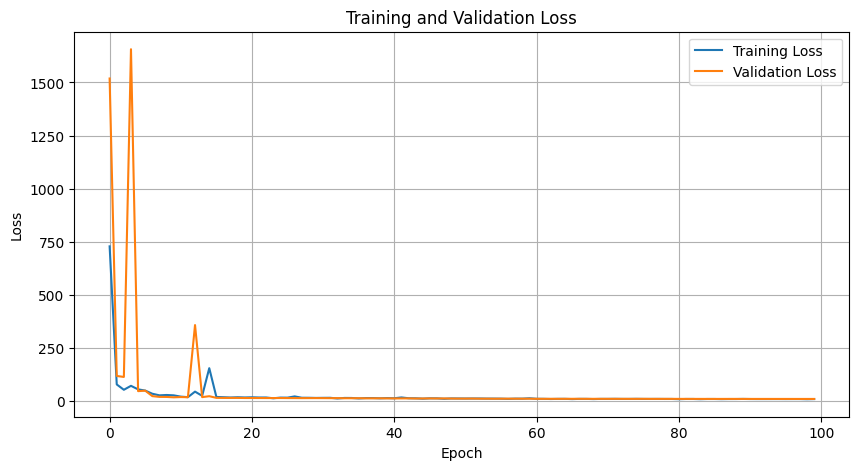

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Построим графики по каждому выходу YOLOv3

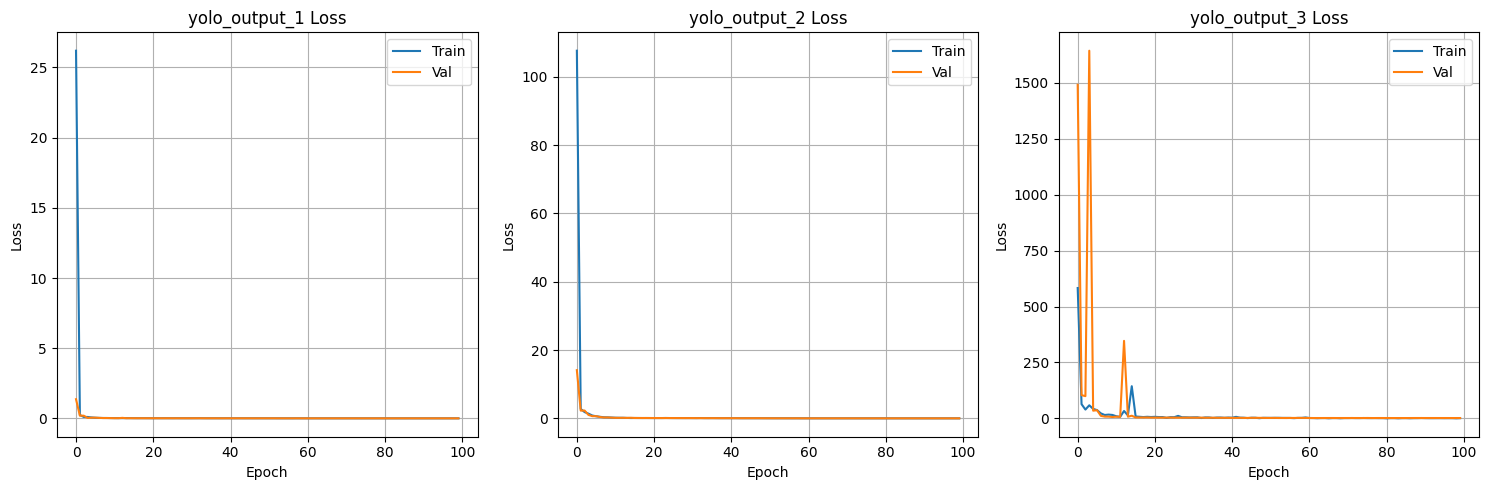

In [ ]:
output_names = ['yolo_output_1', 'yolo_output_2', 'yolo_output_3']

plt.figure(figsize=(15, 5))

for i, name in enumerate(output_names):
    plt.subplot(1, 3, i+1)
    plt.plot(history.history[f'{name}_loss'], label='Train')
    plt.plot(history.history[f'val_{name}_loss'], label='Val')
    plt.title(f'{name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

# Тестирование модели

In [ ]:
def predict_single_image(model, image_path, anchors, anchor_masks, num_classes, size=416):
    """
    Предсказывает объекты на одном изображении

    Args:
        model: обученная модель YOLOv3
        image_path: путь к изображению
        anchors: массив анкеров
        anchor_masks: маски анкеров для каждой голови
        num_classes: число классов
        size: размер входного изображения (например, 416)

    Returns:
        boxes: нормализованные боксы [x1, y1, x2, y2]
        scores: уверенность модели
        classes: индексы классов
    """
    # 1. Загрузка изображения
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    orig_img = img.numpy() if isinstance(img, tf.Tensor) else img
    img = preprocess_image(img, size)

    # 2. Добавляем batch размерность
    img = tf.expand_dims(img, axis=0)  # (1, 416, 416, 3)

    # 3. Предсказание
    preds = model.predict(img)

    # 4. Объединяем выходы YOLO в единый список боксов
    all_boxes = []
    all_scores = []
    all_classes = []

    for i, pred in enumerate(preds):
        boxes, scores, classes = process_yolo_output(
            pred, anchors[anchor_masks[i]], anchor_masks[i], num_classes, score_threshold=0.5
        )
        all_boxes.append(boxes)
        all_scores.append(scores)
        all_classes.append(classes)

    # 5. Объединяем все выходы
    all_boxes = np.concatenate(all_boxes)
    all_scores = np.concatenate(all_scores)
    all_classes = np.concatenate(all_classes)

    # 6. Удаляем лишнюю ось у scores
    all_scores = np.squeeze(all_scores, axis=-1)

    # 7. Применяем NMS
    nms_indices = tf.image.non_max_suppression(
        all_boxes,
        all_scores,
        max_output_size=64,
        iou_threshold=YOLO_IOU_THRESHOLD
    ).numpy()

    # 8. Фильтруем боксы, scores и классы по NMS
    boxes = all_boxes[nms_indices]
    scores = all_scores[nms_indices]
    classes = all_classes[nms_indices]

    return boxes, scores, classes, orig_img


def process_yolo_output(yolo_output, anchors, mask, num_classes, score_threshold=0.5):
    """
    Преобразует выход YOLOv3 в список боксов

    Args:
        yolo_output: выход одного слоя YOLOv3
        anchors: анкеры для этого слоя
        mask: индексы анкеров для этого слоя
        num_classes: число классов
        score_threshold: порог уверенности

    Returns:
        boxes, scores, classes — после фильтрации
    """
    batch_size, grid_h, grid_w, _, _ = yolo_output.shape
    anchors = tf.constant(anchors, dtype=tf.float32)

    # 1. Парсим выход сети
    box_xy, box_wh, obj_probs, class_probs = tf.split(
        yolo_output, (2, 2, 1, num_classes), axis=-1
    )

    box_xy = tf.sigmoid(box_xy)
    obj_probs = tf.sigmoid(obj_probs)
    class_probs = tf.sigmoid(class_probs)

    # 2. Создаем сетку
    grid_x, grid_y = tf.meshgrid(tf.range(grid_h), tf.range(grid_w))
    grid = tf.stack([grid_x, grid_y], axis=-1)
    grid = tf.expand_dims(grid, axis=2)  # shape: (grid_h, grid_w, 1, 2)
    grid = tf.cast(grid, tf.float32)

    # 3. Вычисляем центральные координаты
    box_xy = (box_xy + grid) / tf.cast(grid_h, tf.float32)
    box_wh = tf.exp(box_wh) * anchors / tf.constant(SIZE, dtype=tf.float32)

    # 4. Конвертируем в xmin ymin xmax ymax
    xy_min = box_xy - box_wh / 2
    xy_max = box_xy + box_wh / 2
    boxes = tf.concat([xy_min, xy_max], axis=-1)

    # 5. Извлекаем уверенность и классы
    scores = obj_probs
    classes = class_probs

    # 6. Сворачиваем всё в плоский список
    boxes = tf.reshape(boxes, (-1, 4))  # (batch_size * grid_h * grid_w * anchors_per_cell, 4)
    scores = tf.reshape(scores, (-1, 1))  # (batch_size * grid_h * grid_w * anchors_per_cell, 1)
    classes = tf.reshape(classes, (-1, num_classes))  # (batch_size * grid_h * grid_w * anchors_per_cell, num_classes)

    # 7. Фильтруем по порогу уверенности
    score_thresh_mask = scores >= score_threshold
    boxes = tf.boolean_mask(boxes, score_thresh_mask[:, 0])
    scores = tf.boolean_mask(scores, score_thresh_mask[:, 0])
    classes = tf.boolean_mask(classes, score_thresh_mask[:, 0])

    # 8. Определяем классы
    class_ids = tf.argmax(classes, axis=1).numpy()

    return boxes.numpy(), scores.numpy(), class_ids

def draw_boxes(orig_img, boxes, scores, class_ids, class_names, colors=None):
    """
    Рисует боксы на изображении

    Args:
        orig_img: np.array, исходное изображение (H, W, 3)
        boxes: np.array, координаты боксов [x1, y1, x2, y2] в пикселях
        scores: уверенность модели
        class_ids: индексы классов
        class_names: list, список названий классов
        colors: list, цвета для каждого класса

    Returns:
        Изображение с отрисованными боксами
    """
    height, width, _ = orig_img.shape
    print("Original box coordinates:", boxes)  # Отладочная информация

    # Масштабируем координаты
    boxes[..., 0] = np.clip(boxes[..., 0], 0, 1) * width
    boxes[..., 1] = np.clip(boxes[..., 1], 0, 1) * height
    boxes[..., 2] = np.clip(boxes[..., 2], 0, 1) * width
    boxes[..., 3] = np.clip(boxes[..., 3], 0, 1) * height

    boxes = boxes.astype(int)

    # Фиксированные цвета для 13 классов
    if colors is None:
        colors = [
            (255, 0, 0),   # Красный
            (0, 255, 0),   # Зелёный
            (0, 0, 255),   # Синий
            (255, 255, 0), # Жёлтый
            (0, 255, 255), # Циан
            (255, 0, 255), # Малиновый
            (128, 0, 0),   # Темно-красный
            (0, 128, 0),  # Темно-зелёный
            (0, 0, 128),  # Темно-синий
            (128, 128, 0),# Оливковый
            (0, 128, 128),# Голубой
            (128, 0, 128),# Фиолетовый
            (128, 64, 0)  # Коричневый
        ]

    for i in range(len(scores)):
        x1, y1, x2, y2 = boxes[i]
        cls = class_ids[i]
        score = scores[i]

        label = f"{class_names[cls]} {score:.2f}"
        color = colors[cls % len(colors)]

        # Рисуем прямоугольник
        orig_img = cv2.rectangle(orig_img, (x1, y1), (x2, y2), color, 2)

        # Добавляем текст с белым шрифтом и чёрным контуром
        txt_color = (255, 255, 255)  # Белый текст
        contour_color = (0, 0, 0)    # Чёрный контур

        # Рисуем текст с чёрным контуром
        cv2.putText(orig_img, label, (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.4, contour_color, 2)  # Толстый чёрный контур
        cv2.putText(orig_img, label, (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.4, txt_color, 1)      # Тонкий белый текст

    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

## Тест 1 (одно изображение)

In [ ]:
path = '/content/chess_yolo/test/images/0b47311f426ff926578c9d738d683e76_jpg.rf.40183eae584a653181bbd795ba3c353f.jpg'

In [ ]:
path2 = '/content/chess_yolo/test/images/1c0060ef868bdc326ce5e6389cb6732f_jpg.rf.f02cd668d26a53d9bf001497992b3657.jpg'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Original box coordinates: [[0.5127896  0.08248915 0.51278996 0.08248991]
 [0.51415944 0.07533679 0.5141598  0.07533754]]


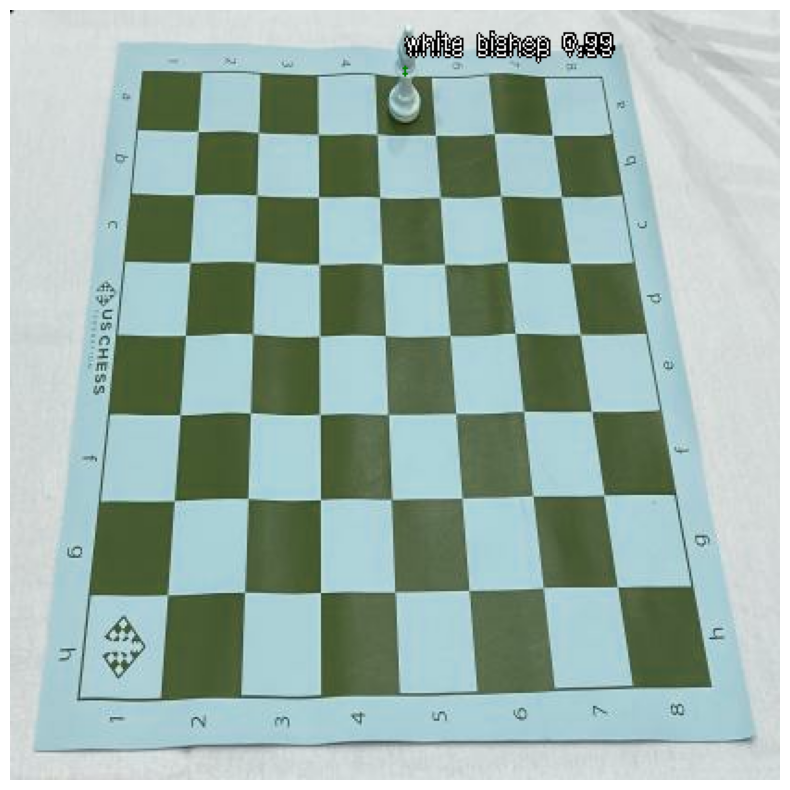

In [ ]:
# Предсказание
boxes, scores, class_ids, orig_img = predict_single_image(
    yolo,
    path,
    yolo_anchors,
    yolo_anchor_masks,
    num_classes,
    SIZE
)

# Отрисовка
draw_boxes(orig_img, boxes, scores, class_ids, CLASS_NAMES)

## Тест 2 (несколько изображений)

In [ ]:
def display_random_images(folder_path, num_images=10):
    """
    Отображает случайные изображения из папки с предсказаниями модели.

    Parameters:
    - folder_path: путь к папке с изображениями
    - num_images: количество отображаемых изображений
    """
    # Получаем список всех изображений в папке
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
    # Выбираем случайные изображения
    selected_files = random.sample(image_files, min(num_images, len(image_files)))

    plt.figure(figsize=(8, 4 * len(selected_files)))  # Настраиваем размер окна

    for i, img_file in enumerate(selected_files):
        image_path = os.path.join(folder_path, img_file)

        # Загружаем изображение
        orig_img = cv2.imread(image_path)
        orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)  # конвертируем в RGB для корректного отображения

        # Предсказание
        boxes, scores, class_ids, orig_img_resized = predict_single_image(
            yolo,
            image_path,
            yolo_anchors,
            yolo_anchor_masks,
            num_classes,
            SIZE
        )

        # Отрисовка боксов
        draw_boxes(orig_img_resized, boxes, scores, class_ids, CLASS_NAMES)

        # Отображение изображения
        plt.subplot(len(selected_files), 1, i + 1)
        plt.imshow(orig_img_resized)
        plt.title(f"Image: {img_file}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Original box coordinates: [[0.60812837 0.342918   0.6081287  0.34291878]
 [0.5220916  0.41922703 0.522092   0.41922817]
 [0.54307175 0.6674673  0.5430721  0.667468  ]
 [0.6019541  0.54529965 0.60195446 0.54530036]
 [0.24629559 0.66751546 0.24629594 0.6675162 ]
 [0.13827424 0.65207344 0.13827468 0.6520743 ]
 [0.3622786  0.529252   0.36227903 0.5292528 ]
 [0.25985178 0.43767118 0.25985214 0.43767184]
 [0.6460001  0.66164315 0.64600056 0.661644  ]
 [0.52208304 0.42646933 0.5220834  0.4264704 ]
 [0.4474153  0.78551376 0.44741565 0.7855145 ]
 [0.5170199  0.41898137 0.5170203  0.41898245]
 [0.26023328 0.34073243 0.26023358 0.34073302]
 [0.16210331 0.4095669  0.16210379 0.40956804]
 [0.44759318 0.7909642  0.44759354 0.7909649 ]
 [0.74261075 0.7812092  0.7426111  0.7812099 ]
 [0.3563733  0.45315084 0.3563736  0.45315155]
 [0.13989173 0.659987   0.13989215 0.6599878 ]
 [0.76604724 0.31065044 0.7660477  0.31065163]
 [0.50771093 0.09152889 0.5077112  0.091529

<Figure size 800x4000 with 0 Axes>

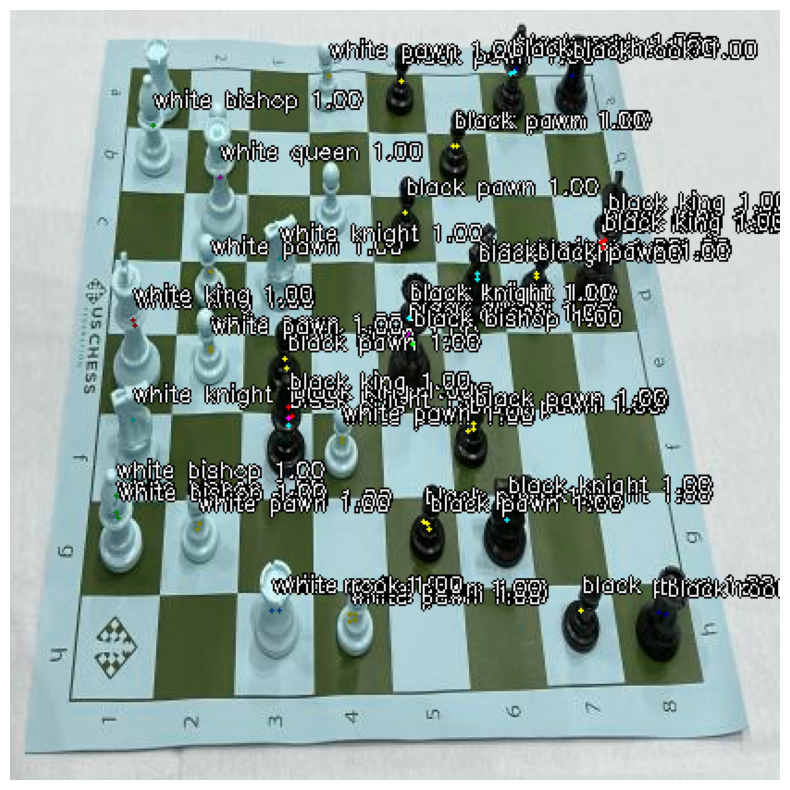

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Original box coordinates: []


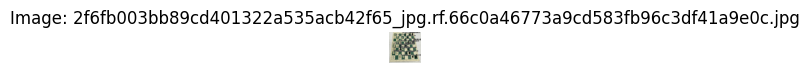

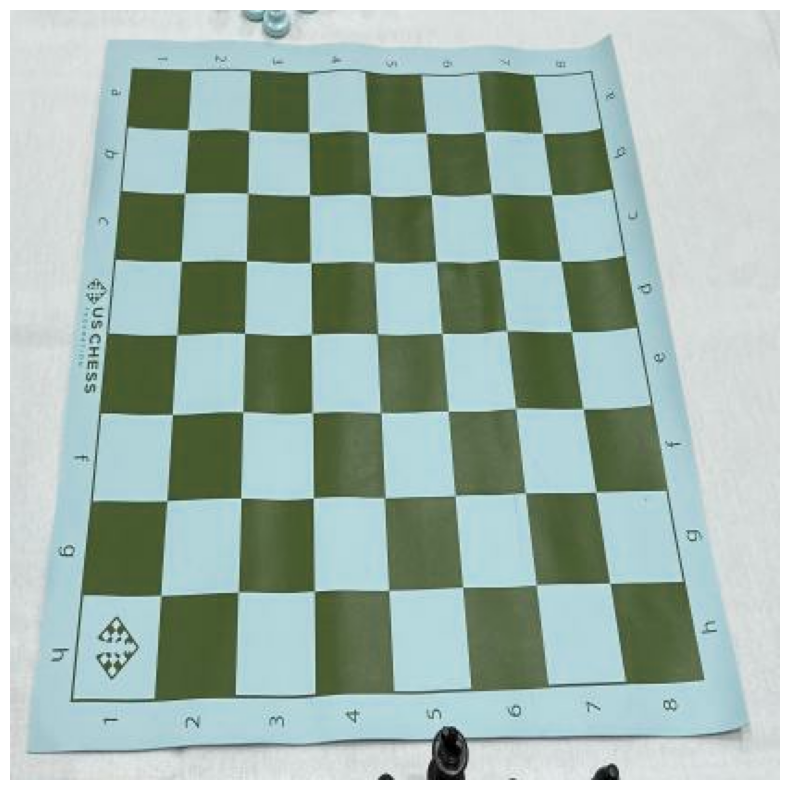

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Original box coordinates: [[0.75653315 0.20828557 0.7565335  0.2082864 ]
 [0.18924089 0.27961573 0.18924128 0.27961668]
 [0.45107254 0.73442954 0.4510729  0.73443025]
 [0.61818063 0.6117561  0.618181   0.6117568 ]
 [0.5912851  0.1279439  0.59128547 0.12794474]
 [0.6459208  0.7397749  0.6459212  0.7397756 ]
 [0.43852928 0.29788852 0.43852958 0.2978891 ]
 [0.4515069  0.7286958  0.45150727 0.7286965 ]
 [0.6772445  0.22445321 0.6772447  0.22445384]
 [0.4444162  0.39548323 0.4444166  0.395484  ]
 [0.5173952  0.30300227 0.51739556 0.30300286]
 [0.44033533 0.39426878 0.44033575 0.39426962]
 [0.78479546 0.3894552  0.7847958  0.3894561 ]
 [0.78372675 0.2962726  0.7837272  0.29627344]
 [0.16837783 0.59270996 0.16837822 0.5927109 ]
 [0.2755021  0.40994403 0.27550238 0.40994468]
 [0.26473764 0.61337006 0.264738   0.61337066]
 [0.7545981  0.21282525 0.75459844 0.21282615]
 [0.43049505 0.13811524 0.43049535 0.13811587]
 [0.70839477 0.60578996 0.7083951  0.605790

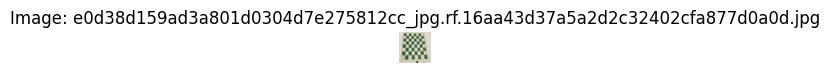

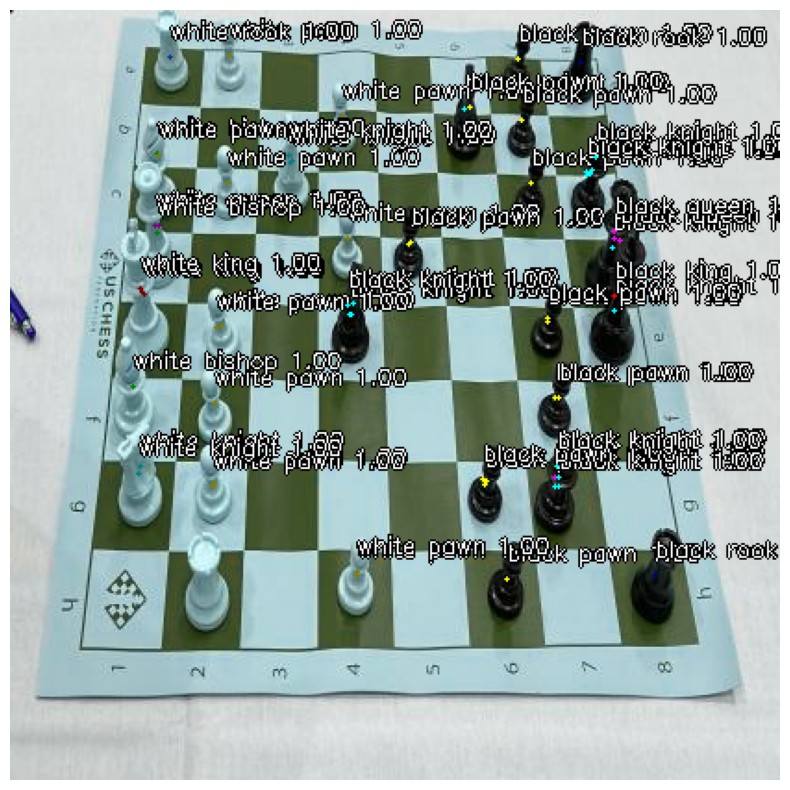

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Original box coordinates: [[0.45411712 0.5539048  0.45411748 0.5539056 ]
 [0.4526399  0.56033415 0.45264032 0.560335  ]
 [0.46224967 0.55333024 0.46225008 0.55333096]
 [0.4536921  0.5369798  0.45369253 0.5369804 ]
 [0.44175294 0.55244446 0.4417533  0.5524453 ]
 [0.46223813 0.5601499  0.46223855 0.56015074]
 [0.45321998 0.55353844 0.45322034 0.55353963]
 [0.44158167 0.5602971  0.44158202 0.5602978 ]
 [0.45081422 0.56312346 0.45081463 0.5631244 ]]


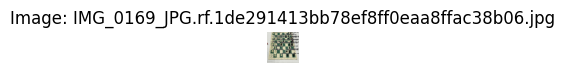

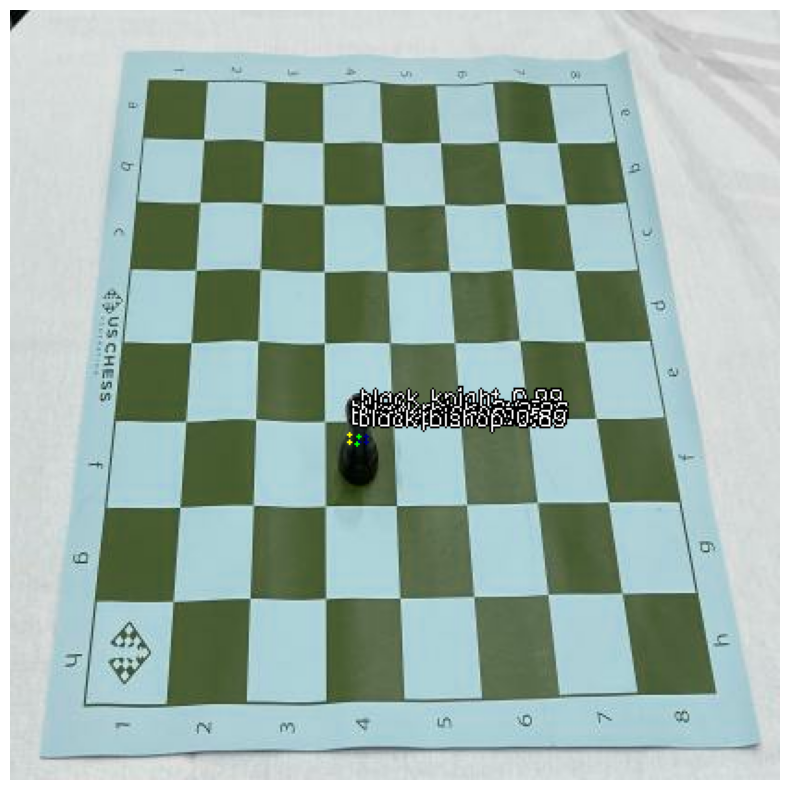

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Original box coordinates: [[0.24258566 0.6331232  0.24258608 0.6331242 ]
 [0.24252048 0.6404386  0.24252093 0.64043957]
 [0.2597845  0.33880344 0.25978485 0.3388041 ]
 [0.684225   0.34122762 0.6842254  0.34122828]
 [0.60777205 0.5356346  0.6077724  0.5356353 ]
 [0.45259023 0.6505579  0.45259064 0.6505588 ]
 [0.54395443 0.66604805 0.5439548  0.66604877]
 [0.34395432 0.15746081 0.34395468 0.15746167]
 [0.35584268 0.5619351  0.35584304 0.56193584]
 [0.34386426 0.15124315 0.34386468 0.15124407]
 [0.76604307 0.3107017  0.76604354 0.3107029 ]
 [0.27222657 0.07323232 0.27222693 0.07323312]
 [0.53668666 0.6637594  0.536687   0.6637601 ]
 [0.6064266  0.54070055 0.60642695 0.54070127]
 [0.16855039 0.31206098 0.16855086 0.31206223]
 [0.27578226 0.16730854 0.27578256 0.1673092 ]
 [0.7670717  0.30193257 0.7670722  0.30193388]
 [0.35500813 0.5559019  0.35500848 0.5559026 ]
 [0.42596307 0.16145083 0.42596337 0.16145164]
 [0.45161715 0.6582513  0.45161757 0.658252

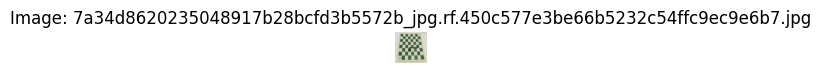

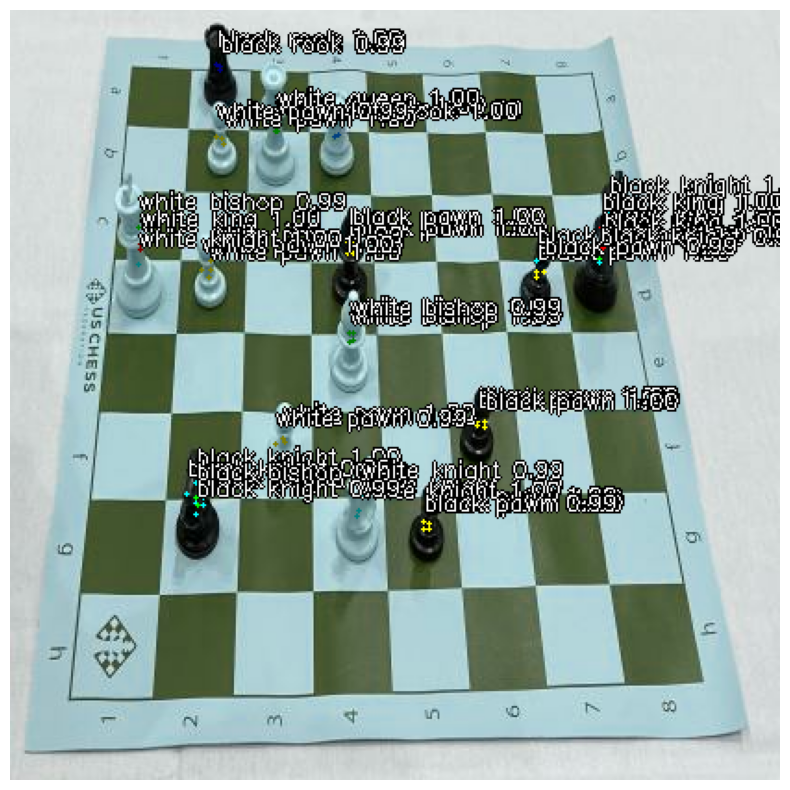

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Original box coordinates: [[0.51648164 0.43752483 0.516482   0.43752566]
 [0.52117264 0.43827745 0.521173   0.43827823]
 [0.5302525  0.6517789  0.5302529  0.6517796 ]
 [0.52944726 0.65664935 0.5294476  0.65665007]
 [0.697571   0.5361304  0.69757134 0.53613114]
 [0.6962606  0.5409223  0.6962609  0.5409229 ]
 [0.34226492 0.5464157  0.34226528 0.5464164 ]
 [0.76457244 0.31087512 0.7645729  0.3108763 ]
 [0.60228586 0.22920214 0.60228634 0.22920309]
 [0.601715   0.23335426 0.6017154  0.23335509]
 [0.7660495  0.3033121  0.76605    0.30331334]
 [0.51518196 0.44358012 0.5151823  0.4435809 ]
 [0.51557195 0.42195377 0.5155723  0.42195448]
 [0.7723071  0.3013548  0.7723076  0.30135605]
 [0.59431493 0.23467875 0.5943153  0.23467955]
 [0.52090967 0.4215557  0.52091    0.42155635]
 [0.43333817 0.23404682 0.43333846 0.23404774]
 [0.7709786  0.3102132  0.7709791  0.31021428]
 [0.7746755  0.2820432  0.77467597 0.2820442 ]
 [0.43451056 0.22513539 0.43451092 0.225136

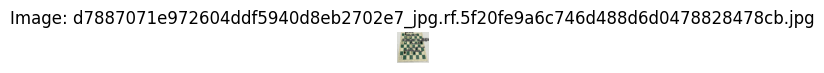

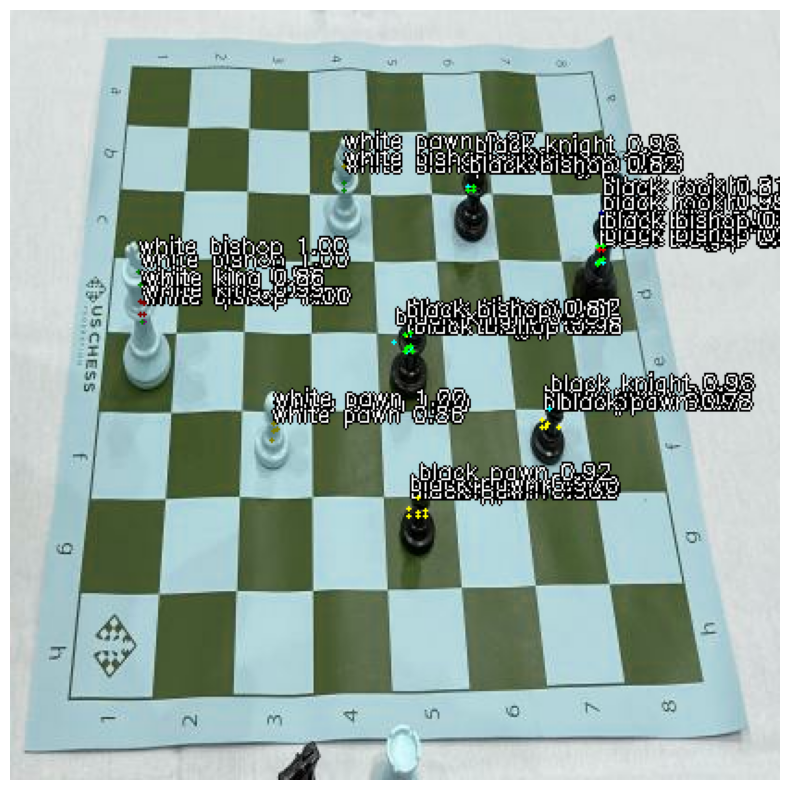

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Original box coordinates: [[0.43827906 0.3032243  0.43827936 0.30322495]
 [0.45170963 0.73704153 0.45171    0.73704225]
 [0.16911387 0.5920705  0.16911429 0.59207135]
 [0.52127737 0.30341354 0.5212776  0.3034142 ]
 [0.60029685 0.29464716 0.60029733 0.29464817]
 [0.4445786  0.39469093 0.444579   0.3946917 ]
 [0.36349076 0.29270098 0.36349112 0.29270205]
 [0.6014926  0.28649592 0.60149294 0.28649694]
 [0.26433602 0.6128088  0.26433638 0.61280954]
 [0.7859799  0.37623215 0.7859804  0.3762334 ]
 [0.43996266 0.39279175 0.43996307 0.39279258]
 [0.6782451  0.22437398 0.67824537 0.22437464]
 [0.6250557  0.50475186 0.625056   0.5047526 ]
 [0.5178213  0.30287558 0.51782155 0.30287617]
 [0.7850324  0.38736326 0.78503275 0.38736427]
 [0.45158687 0.72971463 0.45158717 0.7297152 ]
 [0.26364097 0.6182785  0.26364133 0.6182792 ]
 [0.44698045 0.5926885  0.4469808  0.59268934]
 [0.3665434  0.2940483  0.36654377 0.29404932]
 [0.5230026  0.06723441 0.52300286 0.067235

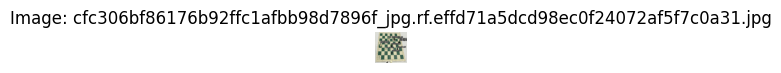

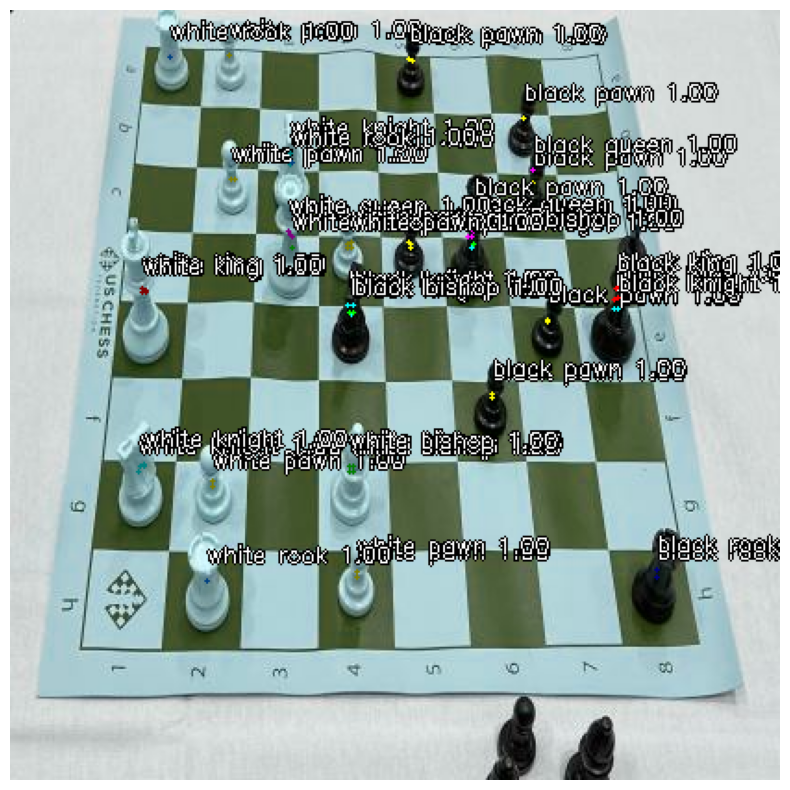

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Original box coordinates: [[0.2422538  0.6331503  0.24225424 0.6331511 ]
 [0.24246845 0.6416431  0.2424689  0.64164406]
 [0.25997296 0.33886942 0.25997332 0.33887008]
 [0.6843476  0.34072766 0.684348   0.3407283 ]
 [0.60754377 0.5355335  0.6075441  0.5355342 ]
 [0.45330933 0.6505354  0.45330974 0.65053636]
 [0.5441433  0.6660175  0.5441437  0.6660182 ]
 [0.34390423 0.15110211 0.34390464 0.15110306]
 [0.3560775  0.56183743 0.35607785 0.56183815]
 [0.76615274 0.3109993  0.7661532  0.3110005 ]
 [0.43576938 0.33838126 0.43576974 0.33838204]
 [0.27221698 0.07312419 0.27221733 0.073125  ]
 [0.3436988  0.1563575  0.34369916 0.15635833]
 [0.6062238  0.54081714 0.6062242  0.54081786]
 [0.44033918 0.4323765  0.44033954 0.43237734]
 [0.53675216 0.6637214  0.5367525  0.6637221 ]
 [0.3551748  0.5557477  0.35517517 0.5557484 ]
 [0.767076   0.30171365 0.7670765  0.30171496]
 [0.16867687 0.31248918 0.16867734 0.31249037]
 [0.2755666  0.16740021 0.2755669  0.167400

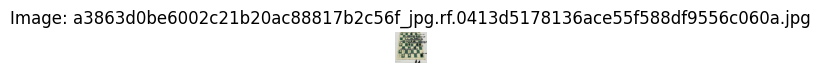

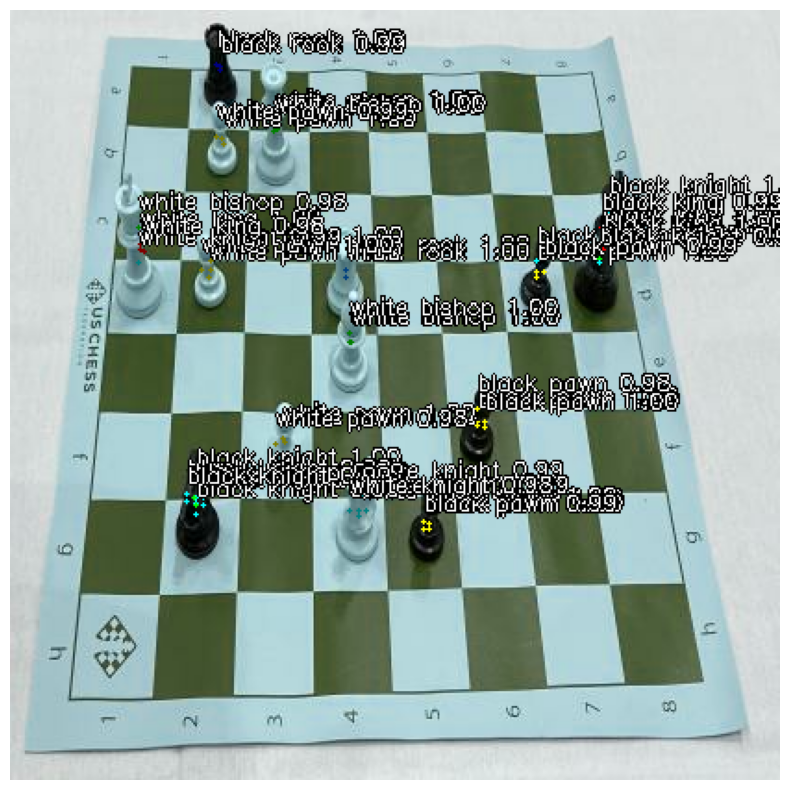

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Original box coordinates: [[0.60149664 0.54629034 0.601497   0.54629105]
 [0.60718113 0.34263498 0.6071815  0.34263575]
 [0.1394565  0.6519889  0.13945691 0.65198976]
 [0.24642575 0.6677652  0.2464261  0.6677659 ]
 [0.36242595 0.5301591  0.36242637 0.53015995]
 [0.14031169 0.66171265 0.1403121  0.6617135 ]
 [0.54333407 0.66709894 0.5433344  0.66709965]
 [0.25923514 0.43884623 0.2592355  0.4388469 ]
 [0.44803575 0.7856525  0.4480361  0.78565323]
 [0.26019478 0.3418427  0.26019508 0.3418433 ]
 [0.4481591  0.7911023  0.44815946 0.791103  ]
 [0.7430885  0.7809728  0.74308884 0.7809735 ]
 [0.5120599  0.26392365 0.51206017 0.2639243 ]
 [0.35631144 0.45293513 0.35631174 0.45293584]
 [0.7060908  0.41511208 0.70609117 0.41511315]
 [0.16393934 0.40868038 0.16393982 0.40868157]
 [0.5078144  0.09191975 0.50781465 0.09192035]
 [0.53661954 0.66471773 0.5366199  0.66471845]
 [0.16272657 0.40284336 0.16272707 0.4028445 ]
 [0.65727764 0.07497301 0.657278   0.074973

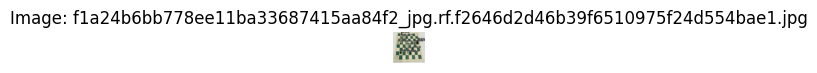

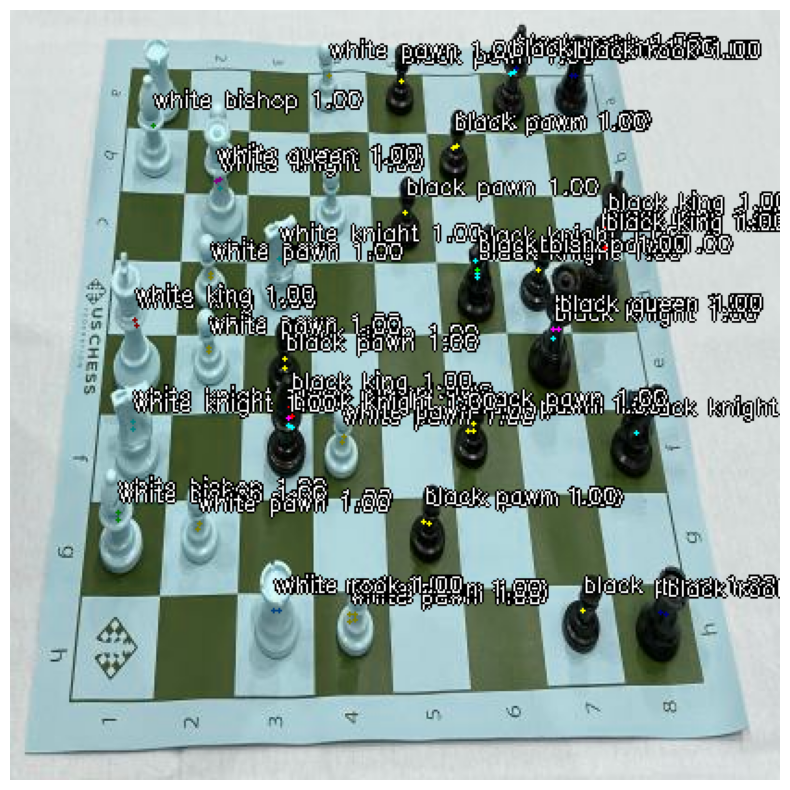

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Original box coordinates: [[0.5323217  0.33907136 0.53232205 0.3390722 ]
 [0.5318627  0.3249197  0.53186303 0.32492054]
 [0.53192824 0.34783733 0.5319286  0.3478381 ]
 [0.5389676  0.33731392 0.53896797 0.3373147 ]
 [0.5309015  0.33843902 0.53090185 0.33844003]
 [0.53016174 0.3258522  0.5301621  0.3258532 ]
 [0.51850075 0.33374986 0.5185011  0.33375052]
 [0.53936917 0.32278243 0.5393695  0.32278332]
 [0.52968705 0.349846   0.5296874  0.34984672]
 [0.53926665 0.3480318  0.539267   0.34803256]
 [0.539212   0.3373523  0.53921235 0.33735308]
 [0.53039426 0.3025165  0.5303946  0.3025171 ]]


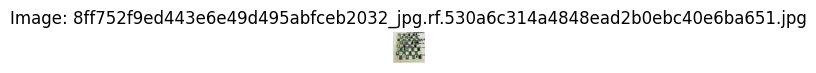

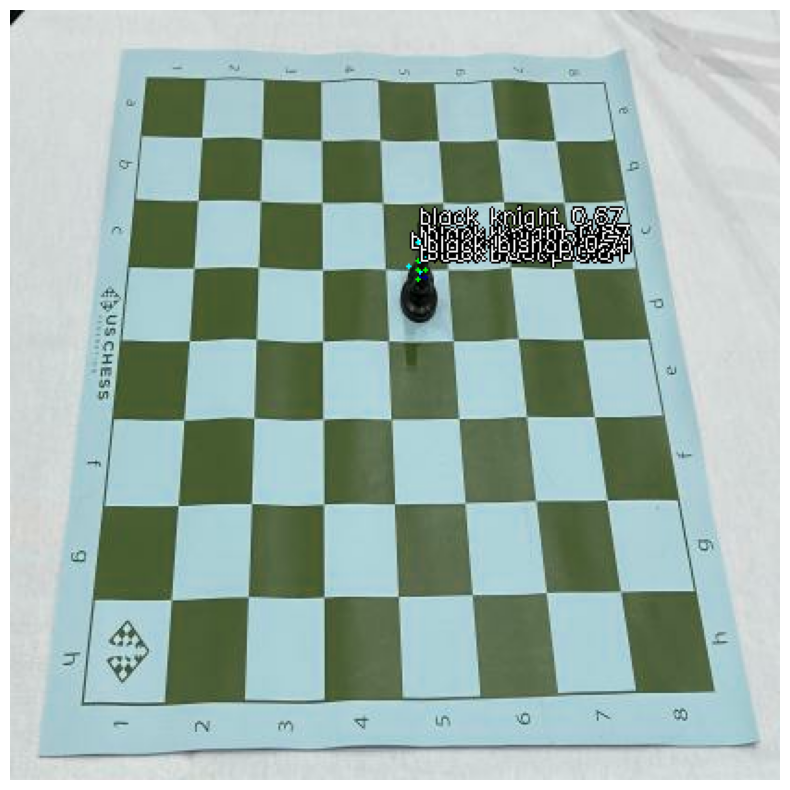

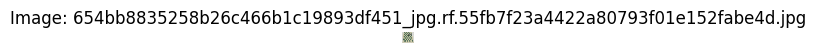

In [ ]:
display_random_images("/content/chess_yolo/test/images")

## Тест 3 (видео)

In [ ]:
def predict_single_image_np(model, image, anchors, anchor_masks, num_classes, size=416):
    """
    Предсказывает объекты на одном изображении

    Args:
        model: обученная модель YOLOv3
        image: np.array, исходное изображение (H, W, 3)
        anchors: массив анкеров
        anchor_masks: маски анкеров для каждой голови
        num_classes: число классов
        size: размер входного изображения (например, 416)

    Returns:
        boxes: нормализованные боксы [x1, y1, x2, y2]
        scores: уверенность модели
        classes: индексы классов
    """
    # 1. Преобразование изображения
    orig_img = image.copy()
    img = preprocess_image(image, size)

    # 2. Добавляем batch размерность
    img = tf.expand_dims(img, axis=0)  # (1, 416, 416, 3)

    # 3. Предсказание
    preds = model.predict(img)

    # 4. Объединяем выходы YOLO в единый список боксов
    all_boxes = []
    all_scores = []
    all_classes = []

    for i, pred in enumerate(preds):
        boxes, scores, classes = process_yolo_output(
            pred, anchors[anchor_masks[i]], anchor_masks[i], num_classes, score_threshold=0.7
        )
        all_boxes.append(boxes)
        all_scores.append(scores)
        all_classes.append(classes)

    # 5. Объединяем все выходы
    all_boxes = np.concatenate(all_boxes)
    all_scores = np.concatenate(all_scores)
    all_classes = np.concatenate(all_classes)

    # 6. Удаляем лишнюю ось у scores
    all_scores = np.squeeze(all_scores, axis=-1)

    # 7. Применяем NMS
    nms_indices = tf.image.non_max_suppression(
        all_boxes,
        all_scores,
        max_output_size=64,
        iou_threshold=YOLO_IOU_THRESHOLD
    ).numpy()

    # 8. Фильтруем боксы, scores и классы по NMS
    boxes = all_boxes[nms_indices]
    scores = all_scores[nms_indices]
    classes = all_classes[nms_indices]

    return boxes, scores, classes, orig_img

In [ ]:
def process_video(model, video_path, anchors, anchor_masks, num_classes, size=416, output_path=None):
    """
    Обрабатывает видео и выделяет объекты

    Args:
        model: обученная модель YOLOv3
        video_path: путь к видеофайлу
        anchors: массив анкеров
        anchor_masks: маски анкеров для каждой голови
        num_classes: число классов
        size: размер входного изображения (например, 416)
        output_path: путь для сохранения выходного видео

    Returns:
        None
    """
    # Открываем видеофайл
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise ValueError(f"Не удалось открыть видеофайл {video_path}")

    # Получаем информацию о видео
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    # Создаем объект для записи видео (если указан output_path)
    if output_path:
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Кодек для MP4
        out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Преобразуем кадр в RGB (YOLOv3 работает с RGB)
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Предсказание объектов
        boxes, scores, classes, _ = predict_single_image_np(
            model,
            frame_rgb,
            anchors,
            anchor_masks,
            num_classes,
            size=size
        )

        # Отрисовка боксов
        draw_boxes(frame, boxes, scores, classes, CLASS_NAMES)

        # Выводим результат
        cv2_imshow(frame)

        # Сохраняем кадр в выходное видео
        if output_path:
            out.write(frame)

        # Выход по нажатию клавиши 'q'
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Освобождаем ресурсы
    cap.release()
    if output_path:
        out.release()
    cv2.destroyAllWindows()

In [ ]:
process_video(
    yolo,  # Твоя загруженная модель
    "/content/chess_yolo/video.mp4",  # Путь к входному видео
    yolo_anchors,  # Анкеры
    yolo_anchor_masks,  # Маски анкеров
    num_classes,  # Число классов
    size=416,  # Размер входного изображения
    output_path="output_video.mp4"  # Путь для сохранения выходного видео
)